# Theory
Modelling with h2o 

* How to create a preprocessing pipeline to iteratively combine data into a human readable format
* How to use the recipes package for preparing the data in a machine readable format (recap)
* How to perform a Correlation Analysis, which helps make sure we have good features before spending time on modeling
* How to make predictions with H2O Automated Machine Learning (primary modeling package and function that we implement in this session)

# Business Case

# 1 Data Processing
* Data processing pipeline using previous data 
* Data has 2 columns: feature name | feature code + feature description

In [1]:
# Load data
library(tidyverse)
library(readxl)

employee_attrition_tbl <- read_csv("/kaggle/input/bdml-dataset/datasets-1067-1925-WA_Fn-UseC_-HR-Employee-Attrition.csv")
definitions_raw_tbl    <- read_excel("/kaggle/input/bdml-dataset/Business Decisions with Machine Learning/Business Decisions with Machine Learning/data_definitions.xlsx", sheet = 1, col_names = FALSE)
View(definitions_raw_tbl)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
• `` -> `...2`


...1,...2
<chr>,<chr>
Education,1 'Below College'
NA,2 'College'
NA,3 'Bachelor'
NA,4 'Master'
NA,5 'Doctor'
NA,NA
EnvironmentSatisfaction,1 'Low'
NA,2 'Medium'
NA,3 'High'


## 1.1 Make data readable

**Tidy up data, and giving information to the number keys**

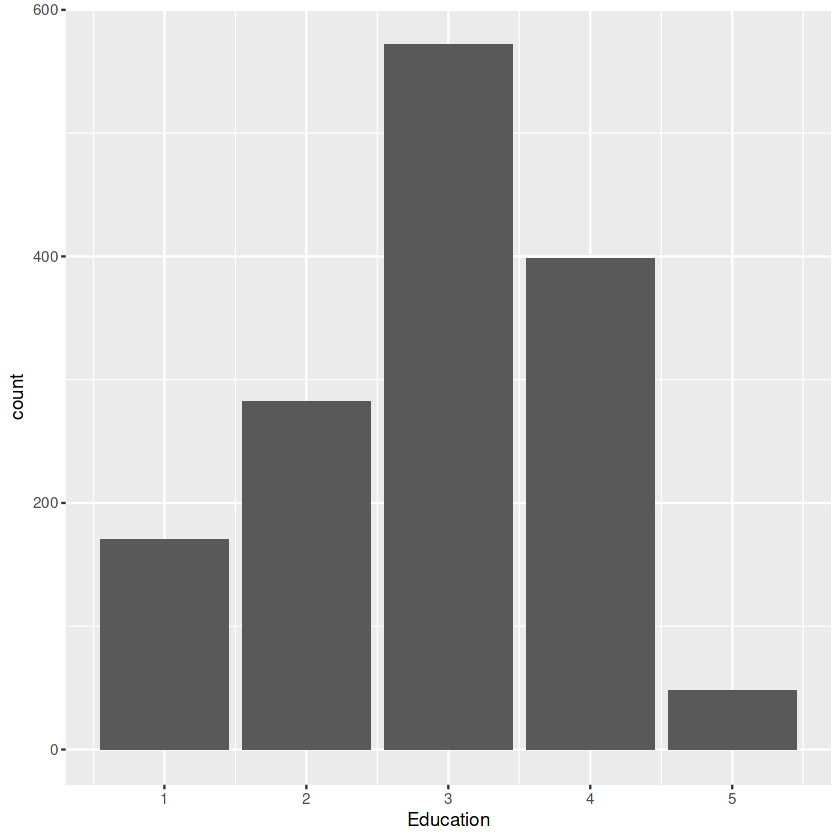

In [2]:
employee_attrition_tbl %>% 
        ggplot(aes(Education)) +
        geom_bar()

In [3]:
# Data preparation ----
# Human readable

definitions_tbl <- definitions_raw_tbl %>% 
  fill(...1, .direction = "down") %>%
  filter(!is.na(...2)) %>%
  separate(...2, into = c("key", "value"), sep = " '", remove = TRUE) %>%
  rename(column_name = ...1) %>%
  mutate(key = as.numeric(key)) %>%
  mutate(value = value %>% str_replace(pattern = "'", replacement = "")) 
definitions_tbl

column_name,key,value
<chr>,<dbl>,<chr>
Education,1,Below College
Education,2,College
Education,3,Bachelor
Education,4,Master
Education,5,Doctor
EnvironmentSatisfaction,1,Low
EnvironmentSatisfaction,2,Medium
EnvironmentSatisfaction,3,High
EnvironmentSatisfaction,4,Very High


**Mapping key over lists**

In [4]:
definitions_list <- definitions_tbl %>% 
  
  # Mapping over lists
  
  # Split into multiple tibbles
  split(.$column_name) %>%
  # Remove column_name
  map(~ select(., -column_name)) %>%
  # Convert to factors because they are ordered an we want to maintain that order
  map(~ mutate(., value = as_factor(value))) 
  
# definitions_list[[1]]
definitions_list[["Education"]]

key,value
<dbl>,<fct>
1,Below College
2,College
3,Bachelor
4,Master
5,Doctor


**Renaming columns for better understanding**

In [5]:
# Rename columns
for (i in seq_along(definitions_list)) {
  list_name <- names(definitions_list)[i]
  colnames(definitions_list[[i]]) <- c(list_name, paste0(list_name, "_value"))
}

definitions_list[["Education"]]

Education,Education_value
<dbl>,<fct>
1,Below College
2,College
3,Bachelor
4,Master
5,Doctor


**Iterative merge with reduce()**

In [6]:
data_merged_tbl <- list(HR_Data = employee_attrition_tbl) %>%
        
        # Join everything
        append(definitions_list, after = 1) %>%
        reduce(left_join) %>%
        
        # Remove unnecessary columns
        select(-one_of(names(definitions_list))) %>%
        
        # Format the "_value"
        set_names(str_replace_all(names(.), pattern = "_value", replacement = "")) %>%
        
        # Resort
        select(sort(names(.))) 

Joining with `by = join_by(Education)`
Joining with `by = join_by(EnvironmentSatisfaction)`
Joining with `by = join_by(JobInvolvement)`
Joining with `by = join_by(JobSatisfaction)`
Joining with `by = join_by(PerformanceRating)`
Joining with `by = join_by(RelationshipSatisfaction)`
Joining with `by = join_by(WorkLifeBalance)`


* Some data are still in character format

In [7]:
# Return only unique values of BusinessTravel
data_merged_tbl %>% 
  distinct(BusinessTravel)

BusinessTravel
<chr>
Travel_Rarely
Travel_Frequently
Non-Travel


**Mutate to factors**

In [8]:
data_merged_tbl %>%
        mutate_if(is.character, as.factor) %>%
        glimpse()

Rows: 1,470
Columns: 35
$ Age                      <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2…
$ Attrition                <fct> Yes, No, Yes, No, No, No, No, No, No, No, No,…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rare…
$ DailyRate                <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 1358,…
$ Department               <fct> Sales, Research & Development, Research & Dev…
$ DistanceFromHome         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26, …
$ Education                <fct> College, Below College, College, Master, Belo…
$ EducationField           <fct> Life Sciences, Life Sciences, Other, Life Sci…
$ EmployeeCount            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ EmployeeNumber           <dbl> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,…
$ EnvironmentSatisfaction  <fct> Medium, High, Very High, Very High, Low, Very…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Femal…
$ HourlyRate    

**Inspect levels**

In [9]:
data_merged_tbl %>%
        mutate_if(is.character, as.factor) %>%
        select_if(is.factor) %>%
        glimpse()
        
data_merged_tbl %>%
        mutate_if(is.character, as.factor) %>%
        select_if(is.factor) %>%
        map(levels)

Rows: 1,470
Columns: 16
$ Attrition                <fct> Yes, No, Yes, No, No, No, No, No, No, No, No,…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rare…
$ Department               <fct> Sales, Research & Development, Research & Dev…
$ Education                <fct> College, Below College, College, Master, Belo…
$ EducationField           <fct> Life Sciences, Life Sciences, Other, Life Sci…
$ EnvironmentSatisfaction  <fct> Medium, High, Very High, Very High, Low, Very…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Femal…
$ JobInvolvement           <fct> High, Medium, Medium, High, High, High, Very …
$ JobRole                  <fct> Sales Executive, Research Scientist, Laborato…
$ JobSatisfaction          <fct> Very High, Medium, High, High, Medium, Very H…
$ MaritalStatus            <fct> Single, Married, Single, Married, Married, Si…
$ Over18                   <fct> Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, Y, …
$ OverTime      

$Attrition
[1] "No"  "Yes"

$BusinessTravel
[1] "Non-Travel"        "Travel_Frequently" "Travel_Rarely"    

$Department
[1] "Human Resources"        "Research & Development" "Sales"                 

$Education
[1] "Below College" "College"       "Bachelor"      "Master"       
[5] "Doctor"       

$EducationField
[1] "Human Resources"  "Life Sciences"    "Marketing"        "Medical"         
[5] "Other"            "Technical Degree"

$EnvironmentSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$Gender
[1] "Female" "Male"  

$JobInvolvement
[1] "Low"       "Medium"    "High"      "Very High"

$JobRole
[1] "Healthcare Representative" "Human Resources"          
[3] "Laboratory Technician"     "Manager"                  
[5] "Manufacturing Director"    "Research Director"        
[7] "Research Scientist"        "Sales Executive"          
[9] "Sales Representative"     

$JobSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$MaritalStatus
[1] "Divorced" "Married"  "Single"  

$Over18
[1] "Y"

$OverTime
[1] "No"  "Yes"

$PerformanceRating
[1] "Low"         "Good"        "Excellent"   "Outstanding"

$RelationshipSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$WorkLifeBalance
[1] "Bad"    "Good"   "Better" "Best"

* Factors for attrition is fine
* Factors for Business Travel is not fine, therefore Travel_Rarely and Travel_Frequently should be flipped, so that it is gradual label
* Factors for Marital Status is not fine, therfore should be changed to gradual label (single > married > divorced)

In [10]:
data_processed_tbl <- data_merged_tbl %>%        
        mutate_if(is.character, as.factor) %>%
        mutate(
            BusinessTravel = BusinessTravel %>% fct_relevel("Non-Travel", 
                                                            "Travel_Rarely", 
                                                            "Travel_Frequently"),
            MaritalStatus  = MaritalStatus %>% fct_relevel("Single", 
                                                           "Married", 
                                                           "Divorced")
        )
        
data_processed_tbl %>% 
  select_if(is.factor) %>% 
  map(levels)

$Attrition
[1] "No"  "Yes"

$BusinessTravel
[1] "Non-Travel"        "Travel_Rarely"     "Travel_Frequently"

$Department
[1] "Human Resources"        "Research & Development" "Sales"                 

$Education
[1] "Below College" "College"       "Bachelor"      "Master"       
[5] "Doctor"       

$EducationField
[1] "Human Resources"  "Life Sciences"    "Marketing"        "Medical"         
[5] "Other"            "Technical Degree"

$EnvironmentSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$Gender
[1] "Female" "Male"  

$JobInvolvement
[1] "Low"       "Medium"    "High"      "Very High"

$JobRole
[1] "Healthcare Representative" "Human Resources"          
[3] "Laboratory Technician"     "Manager"                  
[5] "Manufacturing Director"    "Research Director"        
[7] "Research Scientist"        "Sales Executive"          
[9] "Sales Representative"     

$JobSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$MaritalStatus
[1] "Single"   "Married"  "Divorced"

$Over18
[1] "Y"

$OverTime
[1] "No"  "Yes"

$PerformanceRating
[1] "Low"         "Good"        "Excellent"   "Outstanding"

$RelationshipSatisfaction
[1] "Low"       "Medium"    "High"      "Very High"

$WorkLifeBalance
[1] "Bad"    "Good"   "Better" "Best"

**Function for making data readable**

In [11]:
process_hr_data_readable <- function(data, definitions_tbl) {

    definitions_list <- definitions_tbl %>%
        fill(...1, .direction = "down") %>%
        filter(!is.na(...2)) %>%
        separate(...2, into = c("key", "value"), sep = " '", remove = TRUE) %>%
        rename(column_name = ...1) %>%
        mutate(key = as.numeric(key)) %>%
        mutate(value = value %>% str_replace(pattern = "'", replacement = "")) %>%
        split(.$column_name) %>%
        map(~ select(., -column_name)) %>%
        map(~ mutate(., value = as_factor(value))) 
    
    for (i in seq_along(definitions_list)) {
        list_name <- names(definitions_list)[i]
        colnames(definitions_list[[i]]) <- c(list_name, paste0(list_name, "_value"))
    }
    
    data_merged_tbl <- list(HR_Data = data) %>%
        append(definitions_list, after = 1) %>%
        reduce(left_join) %>%
        select(-one_of(names(definitions_list))) %>%
        set_names(str_replace_all(names(.), pattern = "_value", 
                                            replacement = "")) %>%
        select(sort(names(.))) %>%
        mutate_if(is.character, as.factor) %>%
        mutate(
            BusinessTravel = BusinessTravel %>% fct_relevel("Non-Travel", 
                                                            "Travel_Rarely", 
                                                            "Travel_Frequently"),
            MaritalStatus  = MaritalStatus %>% fct_relevel("Single", 
                                                           "Married", 
                                                           "Divorced")
        )
    
    return(data_merged_tbl)
    
}
process_hr_data_readable(employee_attrition_tbl, definitions_raw_tbl) %>% 
  glimpse()

Joining with `by = join_by(Education)`
Joining with `by = join_by(EnvironmentSatisfaction)`
Joining with `by = join_by(JobInvolvement)`
Joining with `by = join_by(JobSatisfaction)`
Joining with `by = join_by(PerformanceRating)`
Joining with `by = join_by(RelationshipSatisfaction)`
Joining with `by = join_by(WorkLifeBalance)`


Rows: 1,470
Columns: 35
$ Age                      <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2…
$ Attrition                <fct> Yes, No, Yes, No, No, No, No, No, No, No, No,…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rare…
$ DailyRate                <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 1358,…
$ Department               <fct> Sales, Research & Development, Research & Dev…
$ DistanceFromHome         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26, …
$ Education                <fct> College, Below College, College, Master, Belo…
$ EducationField           <fct> Life Sciences, Life Sciences, Other, Life Sci…
$ EmployeeCount            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ EmployeeNumber           <dbl> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,…
$ EnvironmentSatisfaction  <fct> Medium, High, Very High, Very High, Low, Very…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Femal…
$ HourlyRate    

## 1.2 Make data readable for machine

In [12]:
# DATA PREPARATION ----
# Machine readable ----

# libraries
library(rsample)
library(recipes)

# Processing pipeline
# If we had stored our script in an external file
#source("00_scripts/data_processing_pipeline.R")

# If we had our raw data already split into train and test data
#train_readable_tbl <- process_hr_data_readable(train_raw_tbl, definitions_raw_tbl)
#test_redable_tbl   <- process_hr_data_readable(test_raw_tbl, definitions_raw_tbl)

employee_attrition_readable_tbl <- process_hr_data_readable(employee_attrition_tbl, definitions_raw_tbl)

# Split into test and train
set.seed(seed = 1113)
split_obj <- rsample::initial_split(employee_attrition_readable_tbl, prop = 0.85)

# Assign training and test data
train_readable_tbl <- training(split_obj)
test_readable_tbl  <- testing(split_obj)


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


Joining with `by = join_by(Education)`
Joining with `by = join_by(EnvironmentSatisfaction)`
Joining with `by = join_by(JobInvolvement)`
Joining with `by = join_by(JobSatisfaction)`
Joining with `by = join_by(PerformanceRating)`
Joining with `by = join_by(RelationshipSatisfaction)`
Joining with `by = join_by(WorkLifeBalance)`


**Plot all variables**

Examples of what we can see directly:

* DistanceFromHome is pretty skewed
* EmployeeCount, Over18, StandardHours only have one feature

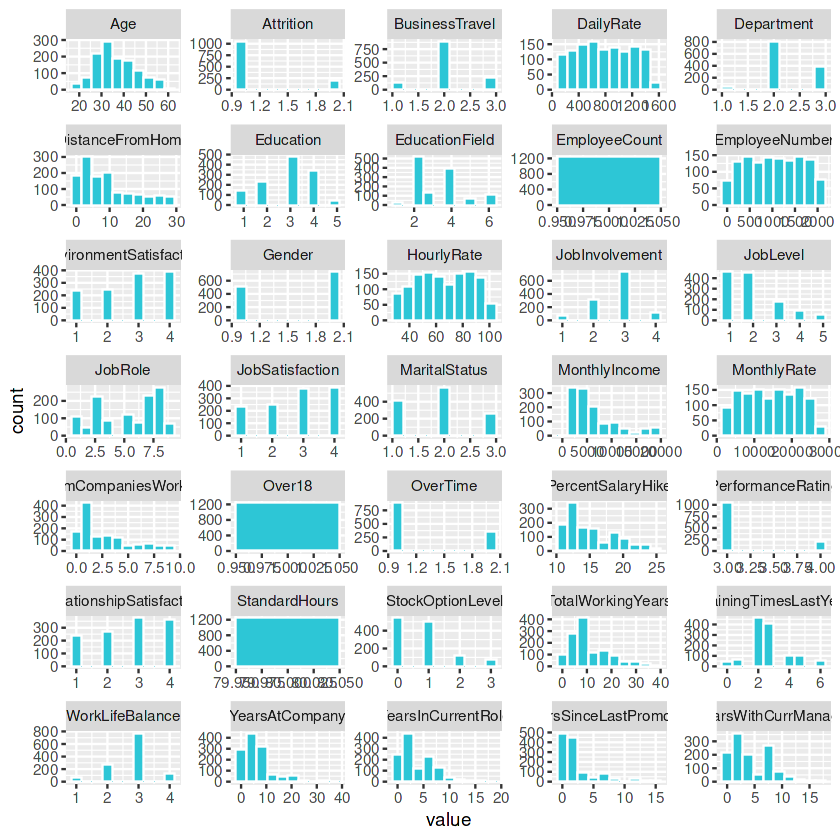

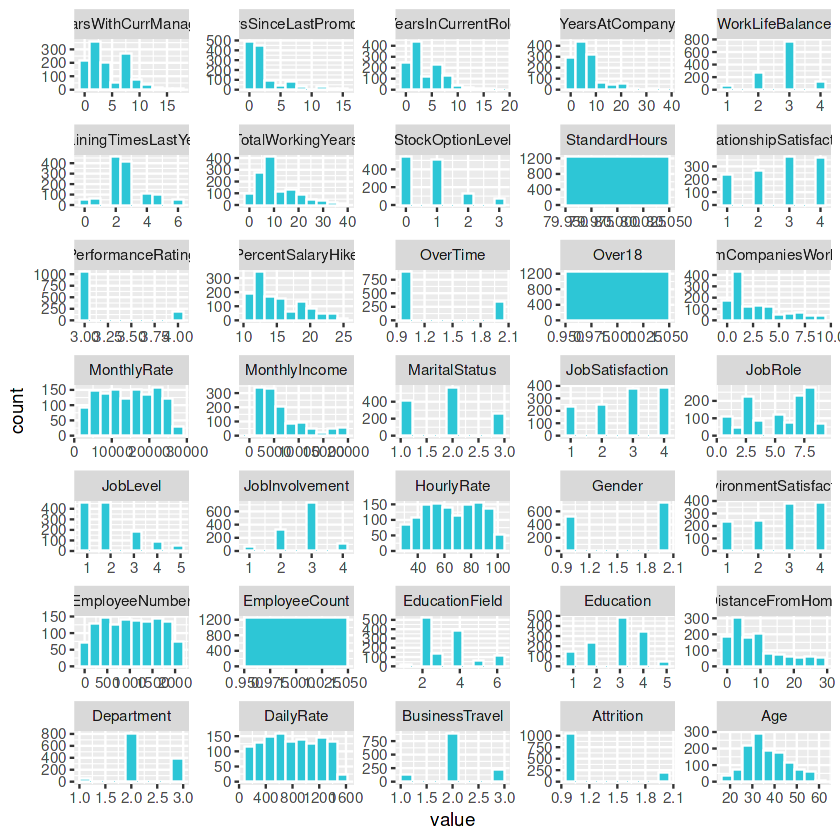

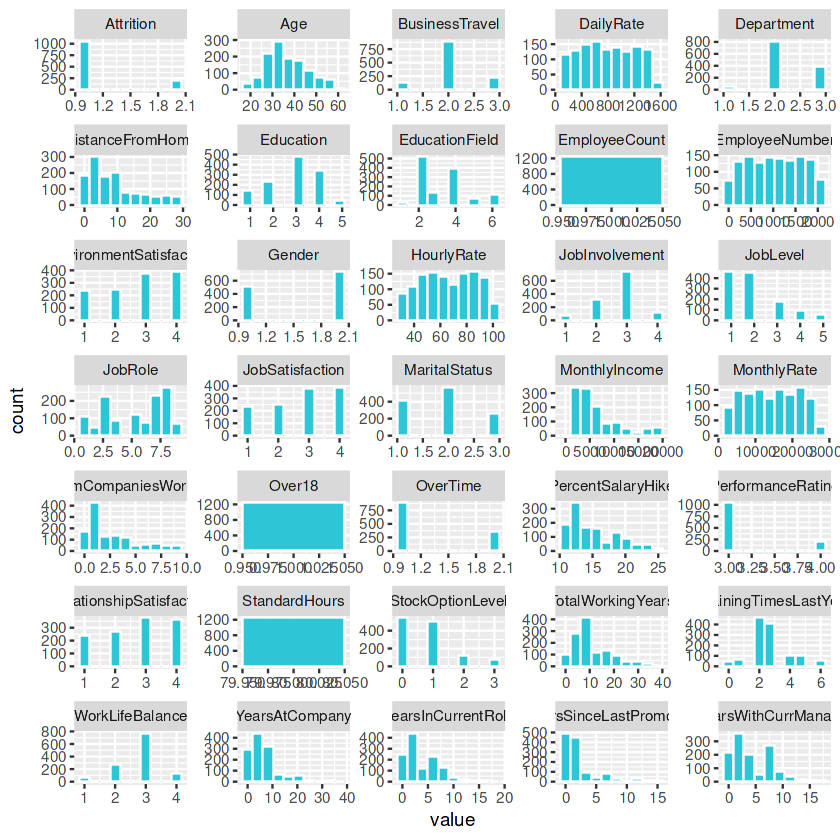

In [13]:
# Plot Faceted Histgoram function

# To create a function and test it, we can assign our data temporarily to data
data <- train_readable_tbl 

plot_hist_facet <- function(data, fct_reorder = FALSE, fct_rev = FALSE, 
                            bins = 10, fill = "#2dc6d6", color = "white", 
                            ncol = 5, scale = "free") {
    
    data_factored <- data %>%
    
        # Convert input to make the function fail safe 
        # (if other content might be provided)
        mutate_if(is.character, as.factor) %>%
        mutate_if(is.factor, as.numeric) %>%
        
        # Data must be in long format to make facets
        pivot_longer(cols = everything(),
                     names_to = "key",
                     values_to = "value",
                     # set key = factor() to keep the order
                     names_transform = list(key = forcats::fct_inorder)) 
    
    if (fct_reorder) {
        data_factored <- data_factored %>%
            mutate(key = as.character(key) %>% as.factor())
    }
    
    if (fct_rev) {
        data_factored <- data_factored %>%
            mutate(key = fct_rev(key))
    }
    
    g <- data_factored %>%
        ggplot(aes(x = value, group = key)) +
        geom_histogram(bins = bins, fill = fill, color = color) +
        facet_wrap(~ key, ncol = ncol, scale = scale)
    
    return(g)
    
}

# Example calls
train_readable_tbl %>% plot_hist_facet()
train_readable_tbl %>% plot_hist_facet(fct_rev = T)

# Bring attirtion to the top (alt.: select(Attrition, everything()))
train_readable_tbl %>% 
  relocate(Attrition) %>% 
  plot_hist_facet()

### 1.2.1 Zero variance Features

In [14]:
# Data Preprocessing With Recipes ----

# Plan: Correlation Analysis

# 1. Zero Variance Features ----

recipe_obj <- recipe(Attrition ~ ., data = train_readable_tbl) %>%
    step_zv(all_predictors())

recipe_obj %>% 
      prep()



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 34



── Training information 

Training data contained 1249 data points and no incomplete rows.



── Operations 

• Zero variance filter removed: EmployeeCount, Over18, StandardHours | Trained



### 1.2.2 Transformation / Skewness 

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is n

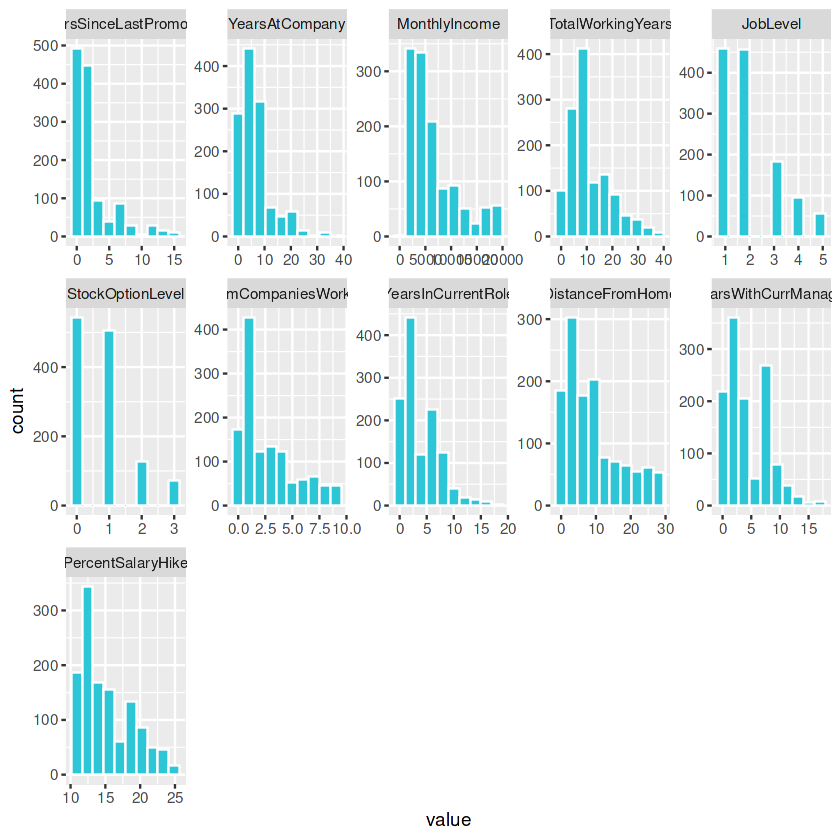

In [15]:
# 2. Transformations ---- (for skewed features)
library(PerformanceAnalytics)  # for skewness  

skewed_feature_names <- train_readable_tbl %>%
    select(where(is.numeric)) %>%
    map_df(skewness) %>%
    pivot_longer(cols = everything(),
                 names_to = "key",
                 values_to = "value",
                 names_transform = list(key = forcats::fct_inorder)) %>%
    arrange(desc(value)) %>%
    
    # Let's set the cutoff value to 0.7 (beccause TrainingTimesLastYear does not seem to be that skewed)
    filter(value >= 0.7) %>%
    pull(key) %>%
    as.character()

train_readable_tbl %>%
    select(all_of(skewed_feature_names)) %>%
    plot_hist_facet()

**JobLevel and StockOptionLevel are factors and should not be transformed. We handle those later with a dummying process.**

In [16]:
!skewed_feature_names %in% c("JobLevel", "StockOptionLevel")

skewed_feature_names <- train_readable_tbl %>%
    select(where(is.numeric)) %>%
    map_df(skewness) %>%
    pivot_longer(cols = everything(),
                 names_to = "key",
                 values_to = "value",
                 names_transform = list(key = forcats::fct_inorder)) %>%
    arrange(desc(value)) %>%
    filter(value >= 0.7) %>%
    filter(!key %in% c("JobLevel", "StockOptionLevel")) %>%
    pull(key) %>%
    as.character()
    
# We need to convert those columns to factors in the next step
factor_names <- c("JobLevel", "StockOptionLevel")

[1]  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

**Let’s fix the skewness (with step_YeoJohnson()) and the factor columns:**

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(skewed_feature_names)

  # Now:
  data %>% select(all_of(skewed_feature_names))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(factor_names)

  # Now:
  data %>% select(all_of(factor_names))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


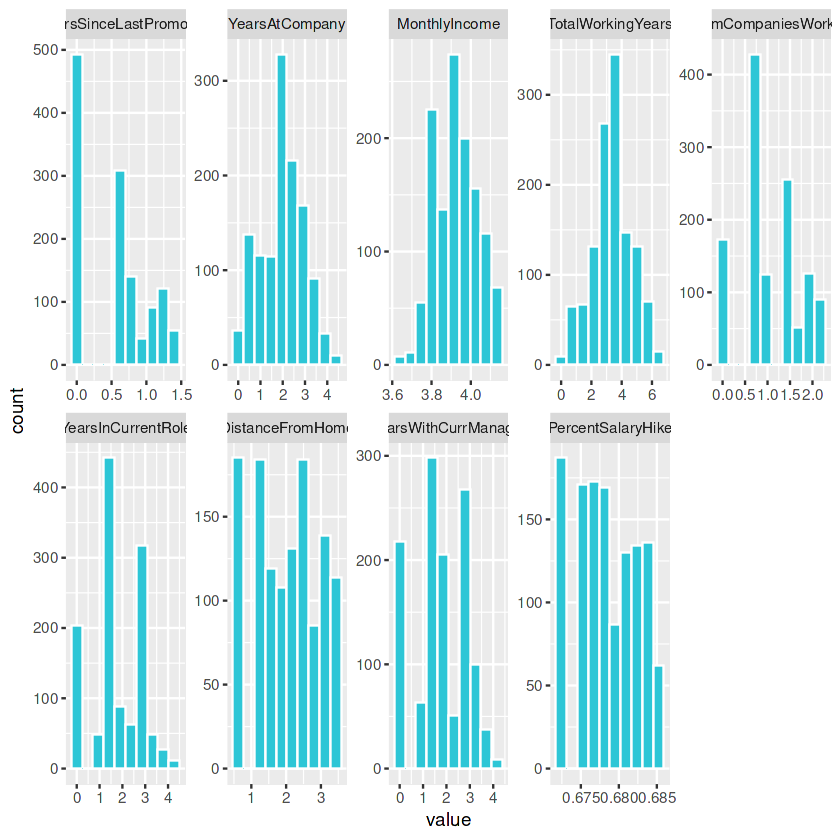

In [17]:
recipe_obj <- recipe(Attrition ~ ., data = train_readable_tbl) %>%
    step_zv(all_predictors()) %>%
    step_YeoJohnson(skewed_feature_names) %>%
    step_mutate_at(factor_names, fn = as.factor)
    
recipe_obj %>% 
    prep() %>% 
    bake(train_readable_tbl) %>% 
    select(skewed_feature_names) %>%
    plot_hist_facet() 

### 1.2.3 Centering & Scaling

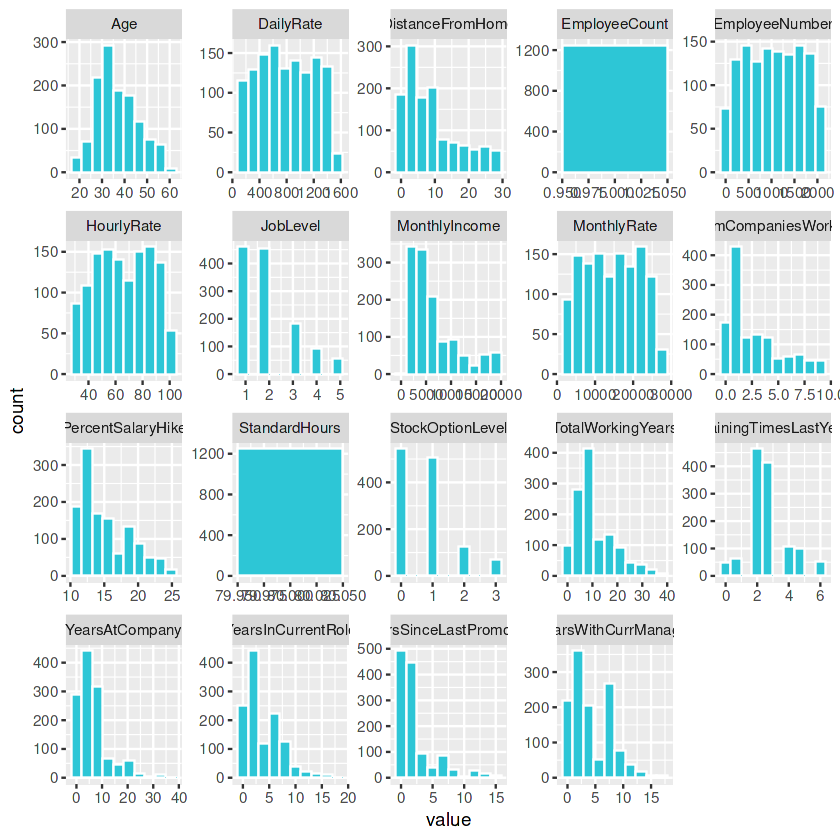

In [18]:
# 3. Center and scale

# Plot numeric data
train_readable_tbl %>% 
  select(where(is.numeric)) %>% 
  plot_hist_facet()

$terms
<list_of<quosure>>

[[1]]
<quosure>
expr: ^all_numeric()
env:  0x580560628ac0


$role
[1] NA

$trained
[1] FALSE

$means
NULL

$na_rm
[1] TRUE

$skip
[1] FALSE

$id
[1] "center_GWd48"

$case_weights
NULL

attr(,"class")
[1] "step_center" "step"       

$terms
<list_of<quosure>>

[[1]]
<quosure>
expr: ^all_numeric()
env:  0x580560628ac0


$role
[1] NA

$trained
[1] TRUE

$means
                    Age               DailyRate        DistanceFromHome 
           3.689672e+01            7.978519e+02            2.009472e+00 
         EmployeeNumber              HourlyRate           MonthlyIncome 
           1.039169e+03            6.595757e+01            3.926886e+00 
            MonthlyRate      NumCompaniesWorked       PercentSalaryHike 
           1.447811e+04            1.050292e+00            6.783763e-01 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
           3.352732e+00            2.786229e+00            2.011652e+00 
     YearsInCurrentRole YearsSinceLastPromotion    YearsWithCurrManager 
           1.727181e+00            5.225350e-01            1.709616e+00 

$na_rm
[1] TRUE

$skip
[1] FALSE

$id
[1] "center_GWd48"

$case_weights
NULL

attr(,"class")
[1] "step_center" "step"       

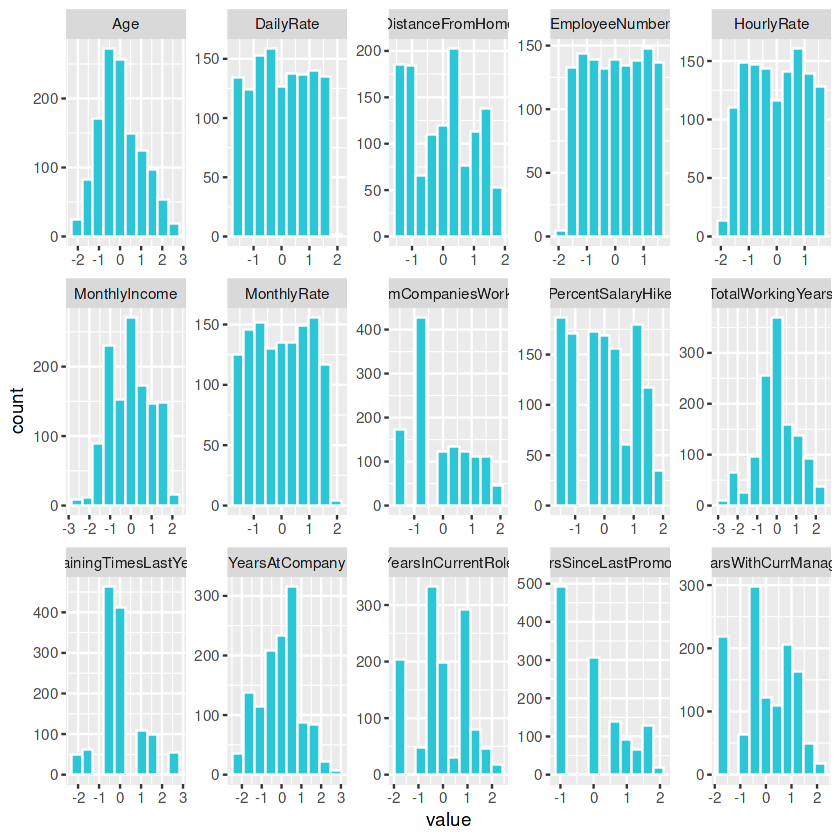

In [19]:
recipe_obj <- recipe(Attrition ~ ., data = train_readable_tbl) %>%
    step_zv(all_predictors()) %>%
    step_YeoJohnson(skewed_feature_names) %>%
    step_mutate_at(factor_names, fn = as.factor) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric())

# You can compare the means attribute before and after prepping the recipe
recipe_obj$steps[[4]] # before prep
prepared_recipe <- recipe_obj %>% prep()
prepared_recipe$steps[[4]]

prepared_recipe %>%
    bake(new_data = train_readable_tbl) %>%
    select(where(is.numeric)) %>% 
    plot_hist_facet()

### 1.2.4 Dummy Variables

In [20]:
# 4. Dummy variables ----

recipe_obj <- recipe(Attrition ~ ., data = train_readable_tbl) %>%
    step_zv(all_predictors()) %>%
    step_YeoJohnson(skewed_feature_names) %>%
    step_mutate_at(factor_names, fn = as.factor) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric()) %>%
    step_dummy(all_nominal()) %>% 
    
    # prepare the final recipe
    prep()

**bake the train & test data**

In [21]:
train_tbl <- bake(recipe_obj, new_data = train_readable_tbl)

train_tbl %>% glimpse()

test_tbl <- bake(recipe_obj, new_data = test_readable_tbl)

Rows: 1,249
Columns: 66
$ Age                                <dbl> 0.12135569, 1.66128715, 0.56133611,…
$ DailyRate                          <dbl> 1.72799052, 1.72799052, 1.16626413,…
$ DistanceFromHome                   <dbl> -1.0115152, -0.4249586, -0.6817922,…
$ EmployeeNumber                     <dbl> -0.80492713, -0.82158646, -0.241841…
$ HourlyRate                         <dbl> -1.19426800, -1.79245965, 1.4477451…
$ MonthlyIncome                      <dbl> -1.86207613, 1.63117757, 0.07274848…
$ MonthlyRate                        <dbl> -0.3347480, -0.5881964, 1.3050466, …
$ NumCompaniesWorked                 <dbl> -0.57820949, 0.02672436, 0.02672436…
$ PercentSalaryHike                  <dbl> 1.6610314, -0.4802126, -0.4802126, …
$ TotalWorkingYears                  <dbl> -2.00413096, 1.96812006, 0.86999363…
$ TrainingTimesLastYear              <dbl> 0.1653511, -0.6081451, -1.3816412, …
$ YearsAtCompany                     <dbl> -1.45454900, -0.05799426, -0.057994…
$ YearsInCurrent

# 2 Correlation Analysis
* Bad features = bad predictions

In [22]:
train_tbl %>%

        # Convert characters & factors to numeric
        mutate(across(where(is.character), as.factor)) %>%
        mutate(across(where(is.factor), as.numeric)) %>%
        
        # Correlation
        cor(use = "pairwise.complete.obs") %>% 
        as_tibble() %>%
        mutate(feature = names(.)) %>% 
        select(feature, Attrition_Yes) %>% 
        
        # Filter the target, because we now the correlation is 100%
        filter(!(feature == "Attrition_Yes")) %>% 
        
        # Convert character back to factors
        mutate(across(where(is.character), as_factor))
        

Warning message in cor(., use = "pairwise.complete.obs"):
“the standard deviation is zero”


feature,Attrition_Yes
<fct>,<dbl>
Age,-0.161863233
DailyRate,-0.062467471
DistanceFromHome,0.079603606
EmployeeNumber,-0.019686125
HourlyRate,-0.015333593
MonthlyIncome,-0.202617100
MonthlyRate,0.013928255
NumCompaniesWorked,0.033238730
PercentSalaryHike,0.002315050


**Get Correlation function**

In [23]:
get_cor <- function(data, target, use = "pairwise.complete.obs",
                    fct_reorder = FALSE, fct_rev = FALSE) {

    feature_expr <- enquo(target)
    feature_name <- quo_name(feature_expr)

    data_cor <- data %>%
        mutate(across(where(is.character), as.factor)) %>%
        mutate(across(where(is.factor), as.numeric)) %>%
        cor(use = use) %>%
        as.tibble() %>%
        mutate(feature = names(.)) %>%
        select(feature, !! feature_expr) %>%
        filter(!(feature == feature_name)) %>%
        mutate_if(is.character, as_factor)

    if (fct_reorder) {
        data_cor <- data_cor %>% 
            mutate(feature = fct_reorder(feature, !! feature_expr)) %>%
            arrange(feature)
    }

    if (fct_rev) {
        data_cor <- data_cor %>% 
            mutate(feature = fct_rev(feature)) %>%
            arrange(feature)
    }

    return(data_cor)

}

**Plot Correlation**

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` instead.
ℹ The signature and semantics have changed, see `?as_tibble`.”
Warning message in cor(., use = use):
“the standard deviation is zero”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `feature = fct_reorder(feature, Attrition_Yes)`.
Caused by warning:
! `fct_reorder()` removing 1 missing value.
ℹ Use `.na_rm = TRUE` to silence this message.
ℹ Use `.na_rm = FALSE` to preserve NAs.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label()`).”


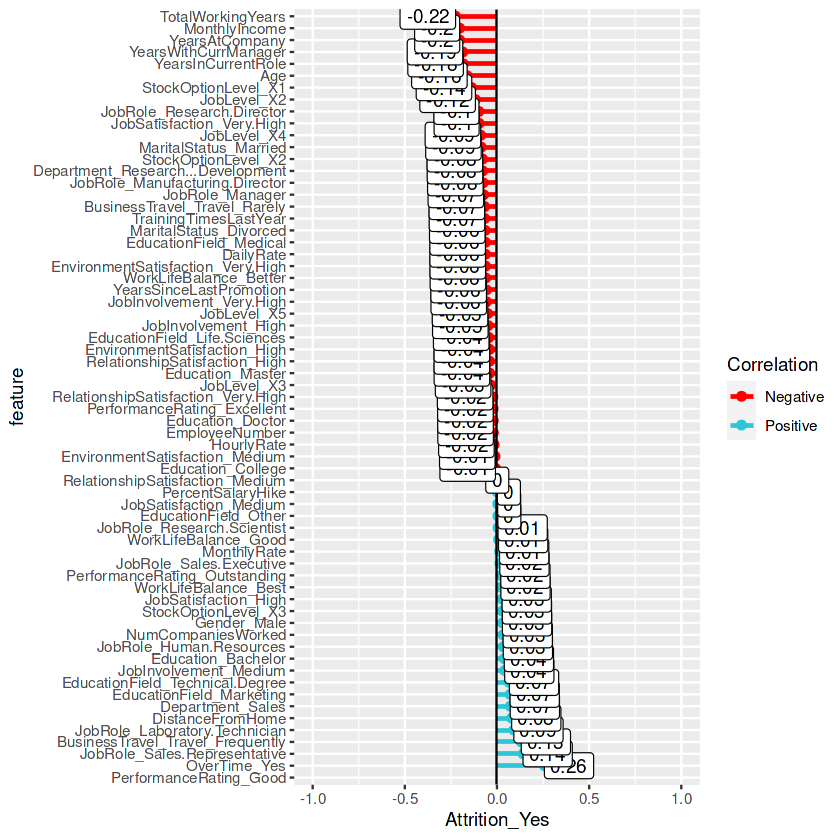

In [24]:
data_cor <- train_tbl %>%

  # Correlation
  get_cor(target = Attrition_Yes, fct_reorder = T, fct_rev = T) %>%
  
  # Create label text
  mutate(feature_name_text = round(Attrition_Yes, digits = 2)) %>%
  
  # Create flags so that we can change the color for poitive and negative
  mutate(Correlation = case_when(
    (Attrition_Yes) >= 0 ~ "Positive",
    TRUE                   ~ "Negative") %>% as.factor())

data_cor %>%
  ggplot(aes(x = Attrition_Yes, y = feature, group = feature)) +
  geom_point(aes(color = Correlation), size = 2) +
  geom_segment(aes(xend = 0, yend = feature, color = Correlation), size = 1) +
  geom_vline(xintercept = 0, color = "black", size = 0.5) +
  expand_limits(x = c(-1, 1)) +
  scale_color_manual(values = c("red", "#2dc6d6")) +
  geom_label(aes(label = feature_name_text), hjust = "outward")

**Create a generic function**

Warning message in cor(., use = use):
“the standard deviation is zero”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `feature = fct_reorder(feature, Attrition_Yes)`.
Caused by warning:
! `fct_reorder()` removing 1 missing value.
ℹ Use `.na_rm = TRUE` to silence this message.
ℹ Use `.na_rm = FALSE` to preserve NAs.”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label()`).”


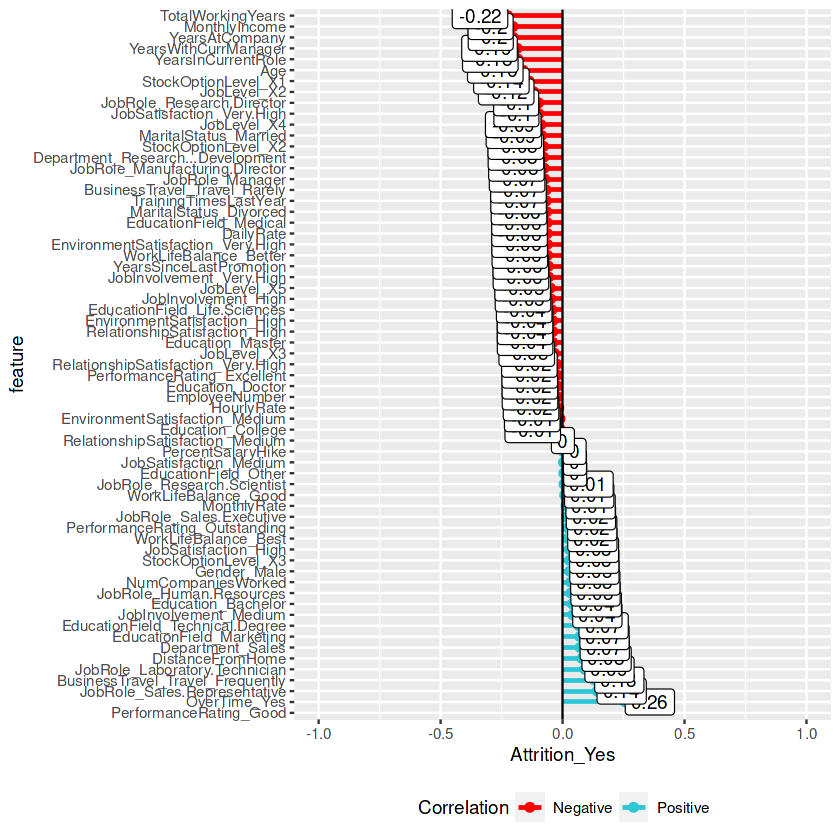

In [25]:
plot_cor <- function(data, target, fct_reorder = FALSE, fct_rev = FALSE, 
                     include_lbl = TRUE, lbl_precision = 2, 
                     lbl_position = "outward",
                     size = 2, line_size = 1, vert_size = 0.5, 
                     color_pos = "#2dc6d6", color_neg = "red") {
  
  feature_expr <- enquo(target)
  
  # Perform correlation analysis
  data_cor <- data %>%
    get_cor(!! feature_expr, fct_reorder = fct_reorder, fct_rev = fct_rev) %>%
    mutate(feature_name_text = round(!! feature_expr, lbl_precision)) %>%
    mutate(Correlation = case_when(
      (!! feature_expr) >= 0 ~ "Positive",
      TRUE                   ~ "Negative") %>% as.factor())
  
  # Plot analysis
  g <- data_cor %>%
    ggplot(aes(x = !! feature_expr, y = feature, group = feature)) +
    geom_point(aes(color = Correlation), size = size) +
    geom_segment(aes(xend = 0, yend = feature, color = Correlation), size = line_size) +
    geom_vline(xintercept = 0, color = "black", size = vert_size) +
    expand_limits(x = c(-1, 1)) +
    scale_color_manual(values = c(color_neg, color_pos)) +
    theme(legend.position = "bottom")
  
  if (include_lbl) g <- g + geom_label(aes(label = feature_name_text), hjust = lbl_position)
  
  return(g)
  
}
plot_cor(data = train_tbl, target = Attrition_Yes, fct_reorder = T, fct_rev = T)

**Example for feature JobRole**

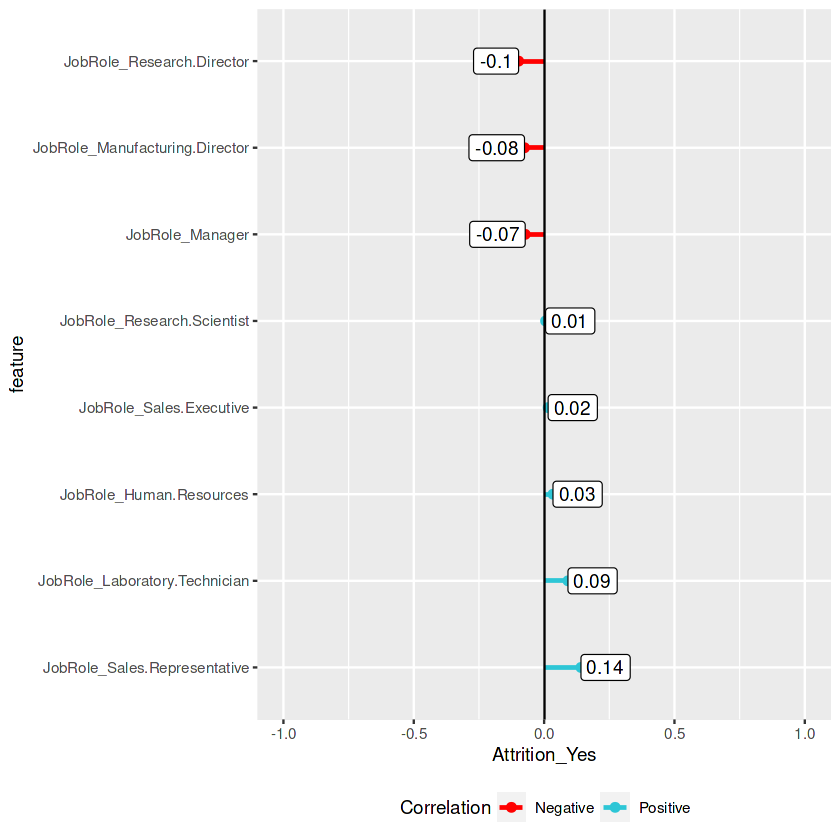

In [26]:
train_tbl %>% 
  select(Attrition_Yes, contains("JobRole")) %>% 
  plot_cor(target = Attrition_Yes, fct_reorder = T, fct_rev = T)

**Correlation Evaluation**

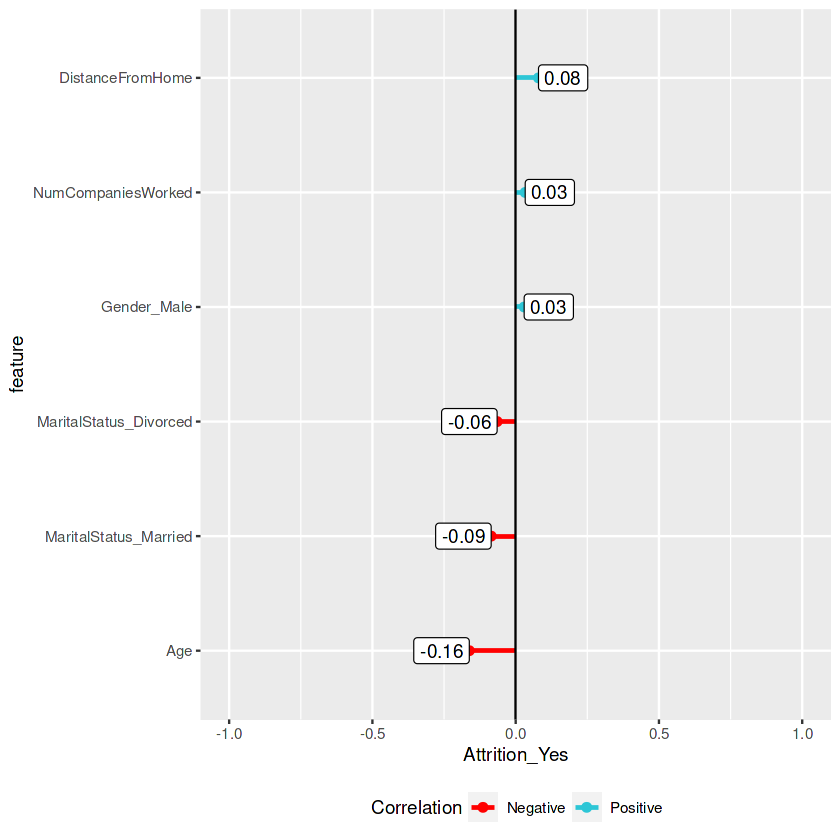

In [27]:
# Correlation Evaluation ----

#   1. Descriptive features: age, gender, marital status 
train_tbl %>%
    select(Attrition_Yes, Age, contains("Gender"), 
           contains("MaritalStatus"), NumCompaniesWorked, 
           contains("Over18"), DistanceFromHome) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = T, fct_rev = F)

**Other categories**

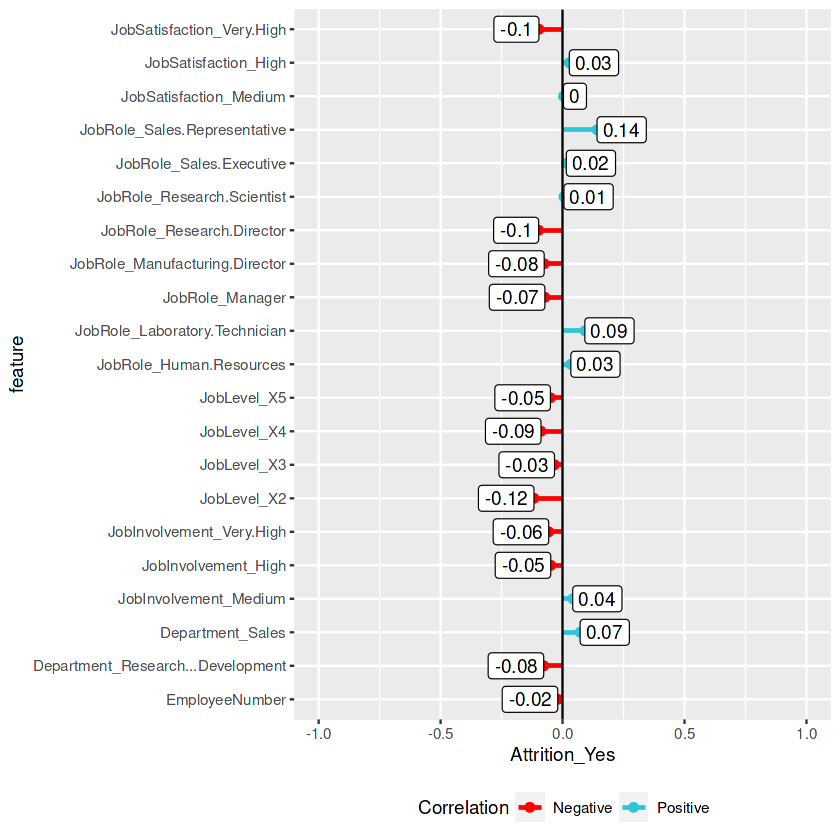

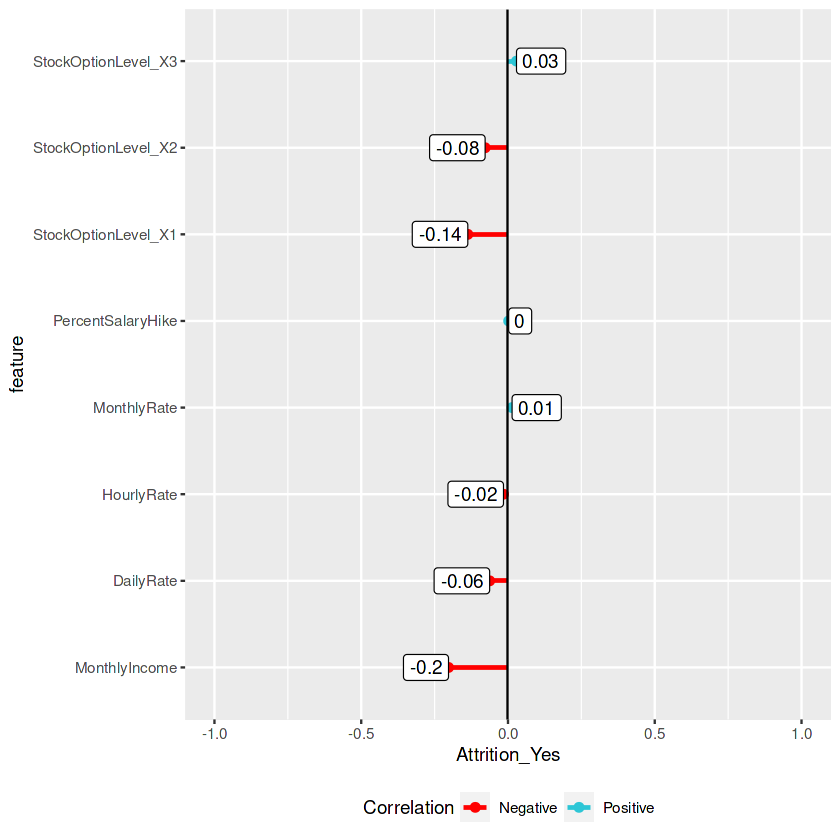

Warning message in cor(., use = use):
“the standard deviation is zero”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_label()`).”


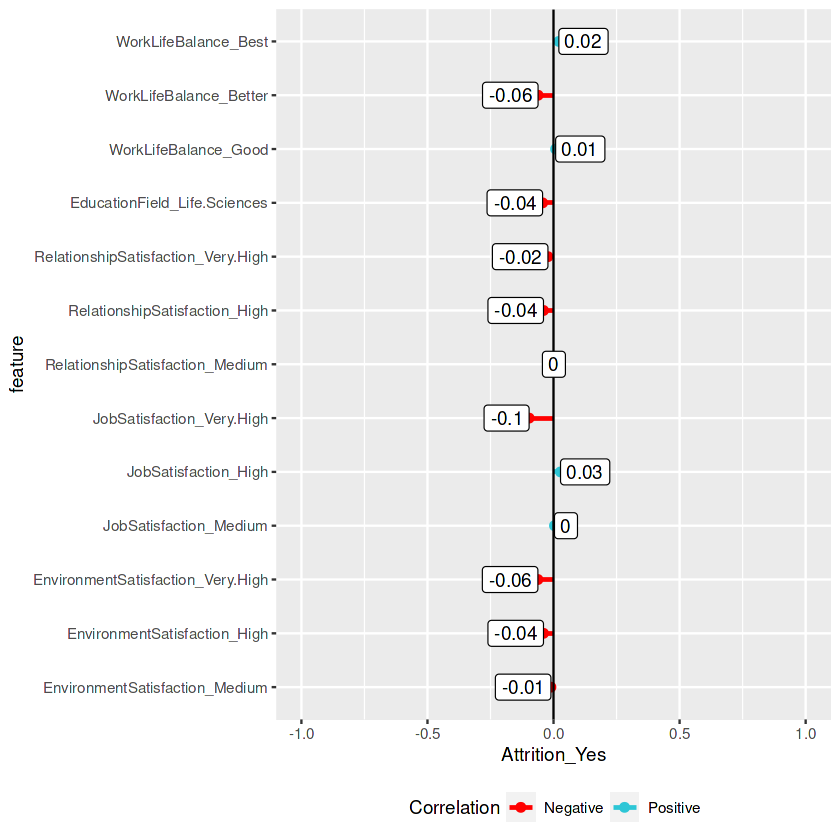

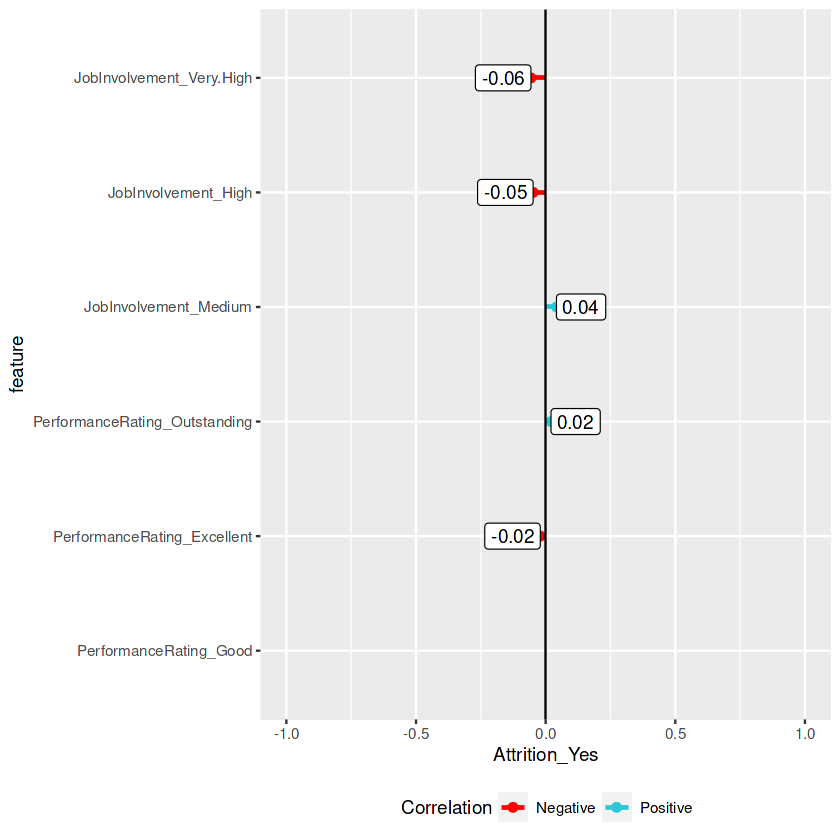

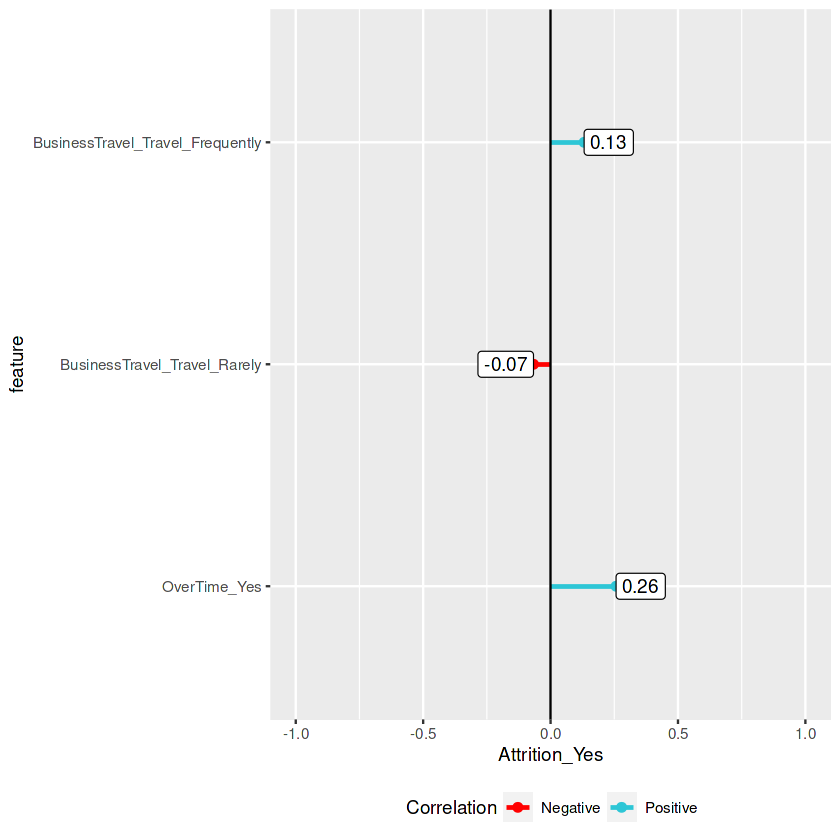

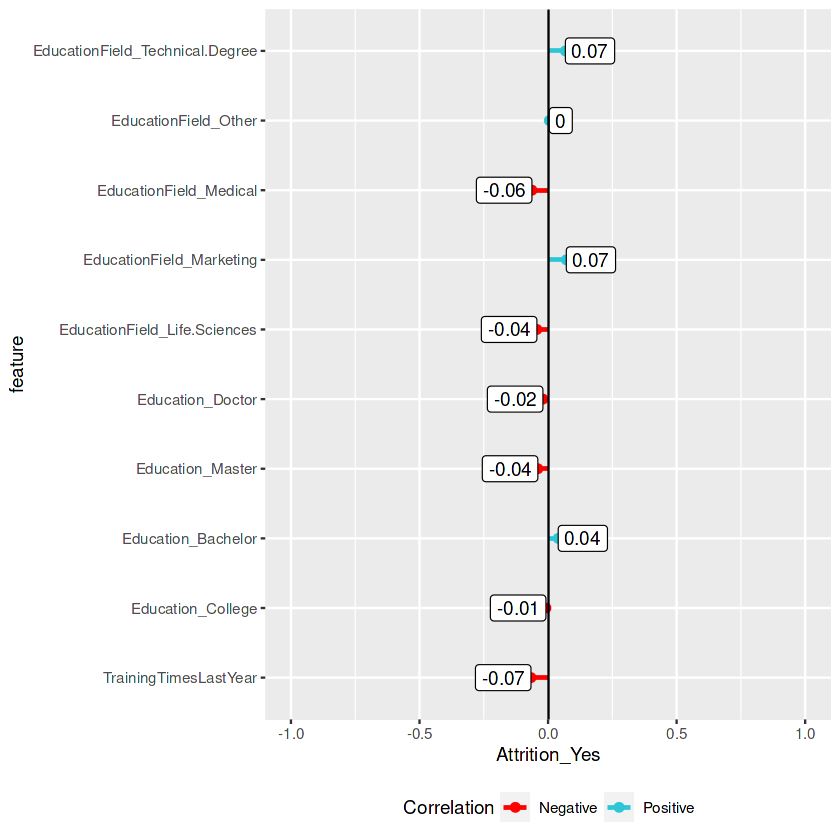

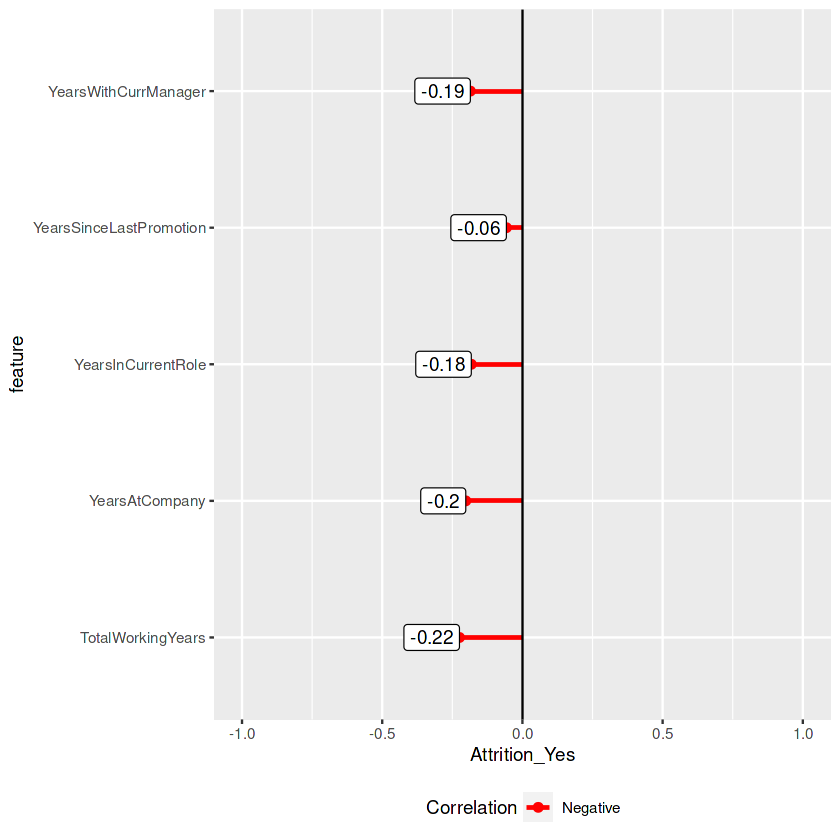

In [28]:
#   2. Employment features: department, job role, job level
train_tbl %>%
     select(Attrition_Yes, contains("employee"), contains("department"), contains("job")) %>%
     plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F) 

#   3. Compensation features: HourlyRate, MonthlyIncome, StockOptionLevel 
train_tbl %>%
    select(Attrition_Yes, contains("income"), contains("rate"), contains("salary"), contains("stock")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

#   4. Survey Results: Satisfaction level, WorkLifeBalance 
train_tbl %>%
    select(Attrition_Yes, contains("satisfaction"), contains("life")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

#   5. Performance Data: Job Involvment, Performance Rating
train_tbl %>%
    select(Attrition_Yes, contains("performance"), contains("involvement")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

#   6. Work-Life Features 
train_tbl %>%
    select(Attrition_Yes, contains("overtime"), contains("travel")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

#   7. Training and Education 
train_tbl %>%
    select(Attrition_Yes, contains("training"), contains("education")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

#   8. Time-Based Features: Years at company, years in current role
train_tbl %>%
    select(Attrition_Yes, contains("years")) %>%
    plot_cor(target = Attrition_Yes, fct_reorder = F, fct_rev = F)

NOTE: positive = attrition, negative = stay

1. Employment Features

Which 3 Job Roles are the least likely to leave?

ANSWER: Research Director, Manufacturing Director, Manager


2. Employment Features

Employees in which Job Level have the lowest likelihood of leaving?

ANSWER: Joblevel X2

# 3 Automated machine learning with h2o 

In [29]:
# H2O modeling
library(h2o)

employee_attrition_tbl          <- read_csv("/kaggle/input/bdml-dataset/datasets-1067-1925-WA_Fn-UseC_-HR-Employee-Attrition.csv")
definitions_raw_tbl             <- read_excel("/kaggle/input/bdml-dataset/Business Decisions with Machine Learning/Business Decisions with Machine Learning/data_definitions.xlsx", sheet = 1, col_names = FALSE)
employee_attrition_readable_tbl <- process_hr_data_readable(employee_attrition_tbl, definitions_raw_tbl)
set.seed(seed = 1113)
split_obj                       <- rsample::initial_split(employee_attrition_readable_tbl, prop = 0.85)
train_readable_tbl              <- training(split_obj)
test_readable_tbl               <- testing(split_obj)

recipe_obj <- recipe(Attrition ~., data = train_readable_tbl) %>% 
    step_zv(all_predictors()) %>% 
    step_mutate_at(JobLevel, StockOptionLevel, fn = as.factor) %>% 
    prep()

train_tbl <- bake(recipe_obj, new_data = train_readable_tbl)
test_tbl  <- bake(recipe_obj, new_data = test_readable_tbl)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:lubridate’:

    day, hour, month, week, year


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
d

In [30]:
# Modeling
h2o.init()

# Split data into a training and a validation data frame
# Setting the seed is just for reproducability
split_h2o <- h2o.splitFrame(as.h2o(train_tbl), ratios = c(0.85), seed = 1234)
train_h2o <- split_h2o[[1]]
valid_h2o <- split_h2o[[2]]
test_h2o  <- as.h2o(test_tbl)

# Set the target and predictors
y <- "Attrition"
x <- setdiff(names(train_h2o), y)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpUWh3bS/file234b6c7008/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpUWh3bS/file237636d0c2/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ..... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 402 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.1 
    H2O cluster version age:    4 months and 6 days 
    H2O cluster name:           H2O_started_from_R_root_drs368 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.50 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:    

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is (4 months and 6 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html”



  |======================================================================| 100%
  |======================================================================| 100%


In [31]:
#?h2o.automl

automl_models_h2o <- h2o.automl(
  x = x,
  y = y,
  training_frame    = train_h2o,
  validation_frame  = valid_h2o,
  leaderboard_frame = test_h2o,
  max_runtime_secs  = 30,
  nfolds            = 5 
)

  |===                                                                   |   5%
  |======================================================================| 100%bled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.


**Inspecting the leaderboard**

In [32]:
typeof(automl_models_h2o)
## "S4"

slotNames(automl_models_h2o)
## [1] "project_name"   "leader"         "leaderboard"    "event_log"      "modeling_steps" "training_info" 

print(automl_models_h2o@leaderboard)

[1] "S4"

[1] "project_name"   "leader"         "leaderboard"    "event_log"     
[5] "modeling_steps" "training_info"

                                                model_id       auc   logloss
1 StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431 0.8583719 0.3461686
2    StackedEnsemble_AllModels_1_AutoML_1_20230615_75431 0.8554186 0.3472195
3 StackedEnsemble_BestOfFamily_1_AutoML_1_20230615_75431 0.8536210 0.3528817
4                          GLM_1_AutoML_1_20230615_75431 0.8536210 0.3519809
5                          GBM_4_AutoML_1_20230615_75431 0.8308937 0.4089356
6                          GBM_1_AutoML_1_20230615_75431 0.8113765 0.3907297
      aucpr mean_per_class_error      rmse       mse
1 0.7095887            0.2242553 0.3205790 0.1027709
2 0.7138599            0.2100668 0.3210153 0.1030508
3 0.7018518            0.2470467 0.3260719 0.1063229
4 0.7018518            0.2470467 0.3227215 0.1041491
5 0.6629691            0.2868516 0.3542270 0.1254768
6 0.6640565            0.2641243 0.3440840 0.1183938

[15 rows x 7 columns] 


**Extracting models from the leaderboard**

In [35]:
# Depending on the algorithm, the output will be different
#h2o.getModel("DeepLearning_grid__1_AutoML_20200820_190823_model_1")
h2o.getModel("StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431")

# Extracts and H2O model name by a position so can more easily use h2o.getModel()
extract_h2o_model_name_by_position <- function(h2o_leaderboard, n = 1, verbose = T) {
    
    model_name <- h2o_leaderboard %>%
        as.tibble() %>%
        slice(n) %>%
        pull(model_id)
    
    if (verbose) message(model_name)
    
    return(model_name)
    
}

automl_models_h2o@leaderboard %>% 
  extract_h2o_model_name_by_position(6) %>% 
  h2o.getModel()

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              3/4
3      # GBM base models (used / total)              1/1
4  # XGBoost base models (used / total)              1/1
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              0/1
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.06095432
RMSE:  0.2468893
LogLoss:  0.2232058
Mean Per-Class Error:  0.1536357
AUC

GBM_1_AutoML_1_20230615_75431



Model Details:

H2OBinomialModel: gbm
Model ID:  GBM_1_AutoML_1_20230615_75431 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              55                       55                7629         3
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         6    4.20000          5          7     6.36364


H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.06914323
RMSE:  0.262951
LogLoss:  0.2422002
Mean Per-Class Error:  0.1471095
AUC:  0.9375634
AUCPR:  0.812539
Gini:  0.8751269
R^2:  0.4444319

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        No Yes    Error      Rate
No     882  27 0.029703   =27/909
Yes     41 114 0.264516   =41/155
Totals 923 141 0.063910  =68/1064

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold      value idx
1                       max f1  0.309358   0.770270 115
2                       max f2  0.231

**Saving and Loading H2O Models**

In [36]:
#h2o.getModel("DeepLearning_grid__1_AutoML_20200820_190823_model_1") %>% 
h2o.getModel("StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431") %>%
  #h2o.saveModel(path = "/kaggle/working/04_Modeling/h20_models/")
    h2o.saveModel(path = "/kaggle/working/")

h2o.loadModel("/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431")

[1] "/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431"

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              3/4
3      # GBM base models (used / total)              1/1
4  # XGBoost base models (used / total)              1/1
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              0/1
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.06095432
RMSE:  0.2468893
LogLoss:  0.2232058
Mean Per-Class Error:  0.1536357
AUC

**Make Predictions**

Because we did a Binary classification, the H2O predictions are 3 columns:

1. Class prediction
1. 1st class probability
1. 2nd class probability

In [37]:
# Choose whatever model you want
stacked_ensemble_h2o <- h2o.loadModel("/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431")
stacked_ensemble_h2o

predictions <- h2o.predict(stacked_ensemble_h2o, newdata = as.h2o(test_tbl))

typeof(predictions)
## [1] "environment"

predictions_tbl <- predictions %>% as_tibble()

Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              3/4
3      # GBM base models (used / total)              1/1
4  # XGBoost base models (used / total)              1/1
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              0/1
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.06095432
RMSE:  0.2468893
LogLoss:  0.2232058
Mean Per-Class Error:  0.1536357
AUC

  |======================================================================| 100%
  |======================================================================| 100%


[1] "environment"

**Recreate model and or tune some values**

In [38]:
deep_learning_h2o <- h2o.loadModel("/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431")

# To see all possible parameters
#?h2o.deeplearning

# to get all paramteres
deep_learning_h2o@allparameters

$model_id
[1] "StackedEnsemble_BestOfFamily_2_AutoML_1_20230615_75431"

$training_frame
[1] "AutoML_1_20230615_75431_training_RTMP_sid_983e_5"

$validation_frame
[1] "RTMP_sid_983e_7"

$base_models
$base_models[[1]]
$base_models[[1]]$`__meta`
$base_models[[1]]$`__meta`$schema_version
[1] 3

$base_models[[1]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[1]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[1]]$name
[1] "GLM_1_AutoML_1_20230615_75431"

$base_models[[1]]$type
[1] "Key<Keyed>"

$base_models[[1]]$URL
NULL


$base_models[[2]]
$base_models[[2]]$`__meta`
$base_models[[2]]$`__meta`$schema_version
[1] 3

$base_models[[2]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[2]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[2]]$name
[1] "GBM_4_AutoML_1_20230615_75431"

$base_models[[2]]$type
[1] "Key<Keyed>"

$base_models[[2]]$URL
NULL


$base_models[[3]]
$base_models[[3]]$`__meta`
$base_models[[3]]$`__meta`$schema_version
[1] 3

$base_models[[3]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[3]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[3]]$name
[1] "XGBoost_1_AutoML_1_20230615_75431"

$base_models[[3]]$type
[1] "Key<Keyed>"

$base_models[[3]]$URL
NULL


$base_models[[4]]
$base_models[[4]]$`__meta`
$base_models[[4]]$`__meta`$schema_version
[1] 3

$base_models[[4]]$`__meta`$schema_name
[1] "KeyV3"

$base_models[[4]]$`__meta`$schema_type
[1] "Key<Keyed>"


$base_models[[4]]$name
[1] "DRF_1_AutoML_1_20230615_75431"

$base_models[[4]]$type
[1] "Key<Keyed>"

$base_models[[4]]$URL
NULL



$metalearner_algorithm
[1] "glm"

$metalearner_nfolds
[1] 5

$metalearner_params
[1] ""

$metalearner_transform
[1] "Logit"

$max_runtime_secs
[1] 1.453333

$seed
[1] "-4355391876976286307"

$score_training_samples
[1] 10000

$keep_levelone_frame
[1] TRUE

$auc_type
[1] "AUTO"

$x
 [1] "Age"                      "BusinessTravel"          
 [3] "DailyRate"                "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "HourlyRate"               "JobInvolvement"          
[13] "JobLevel"                 "JobRole"                 
[15] "JobSatisfaction"          "MaritalStatus"           
[17] "MonthlyIncome"            "MonthlyRate"             
[19] "NumCompaniesWorked"       "OverTime"                
[21] "PercentSalaryHike"        "PerformanceRating"       
[23] "RelationshipSatisfaction" "StockOptionLevel"        
[25] "TotalWorkingYears"        "TrainingTimesLastYear"   
[27] "WorkLifeBalance"          "YearsAtCompany"          
[29] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[31] "YearsWithCurrManager"    

$y
[1] "Attrition"

***

# Challenge
* Predict if product will be in backorder status
* given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales

# 1 Load training and test dataset

In [39]:
product_backorders_tbl <- read_csv("/kaggle/input/bdml-dataset/product_backorders.csv")
View(product_backorders_tbl)

Rows: 19053 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_bu...
dbl (16): sku, national_inv, lead_time, in_transit_qty, forecast_3_month, fo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,⋯,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1113121,0,8,1,6,6,6,0,4,9,⋯,1,0.90,0.89,0,No,No,No,Yes,No,Yes
1113268,0,8,0,2,3,4,1,2,3,⋯,0,0.96,0.97,0,No,No,No,Yes,No,Yes
1113874,20,2,0,45,99,153,16,42,80,⋯,0,0.81,0.88,0,No,No,No,Yes,No,Yes
1114222,0,8,0,9,14,21,5,17,36,⋯,0,0.96,0.98,0,No,No,No,Yes,No,Yes
1114823,0,12,0,31,31,31,7,15,33,⋯,3,0.98,0.98,0,No,No,No,Yes,No,Yes
1115453,55,8,0,216,360,492,30,108,275,⋯,0,0.00,0.00,0,No,No,Yes,Yes,No,Yes
1115620,-34,8,0,120,240,240,83,122,144,⋯,0,1.00,0.97,34,No,No,No,Yes,No,Yes
1116446,4,9,0,43,67,115,5,22,40,⋯,0,0.69,0.68,0,No,No,No,Yes,No,Yes
1116834,2,8,0,4,6,9,1,5,6,⋯,0,1.00,0.95,0,No,No,No,Yes,No,Yes


**Get varaibles names list**

In [40]:
column_names <- names(product_backorders_tbl)
print(column_names)

 [1] "sku"               "national_inv"      "lead_time"        
 [4] "in_transit_qty"    "forecast_3_month"  "forecast_6_month" 
 [7] "forecast_9_month"  "sales_1_month"     "sales_3_month"    
[10] "sales_6_month"     "sales_9_month"     "min_bank"         
[13] "potential_issue"   "pieces_past_due"   "perf_6_month_avg" 
[16] "perf_12_month_avg" "local_bo_qty"      "deck_risk"        
[19] "oe_constraint"     "ppap_risk"         "stop_auto_buy"    
[22] "rev_stop"          "went_on_backorder"


**Split data**

In [51]:
# Split into test and train
set.seed(seed = 1113)
split_obj_challenge_1 <- rsample::initial_split(product_backorders_tbl, prop = 0.8)

# Assign training and test data
train_readable_tbl_challenge_1 <- training(split_obj_challenge_1)
test_readable_tbl_challenge_1  <- testing(split_obj_challenge_1)

#train_tbl_challenge_1
#test_tbl_challenge_1

**Histogram facet**

Warning message:
“Removed 876 rows containing non-finite values (`stat_bin()`).”


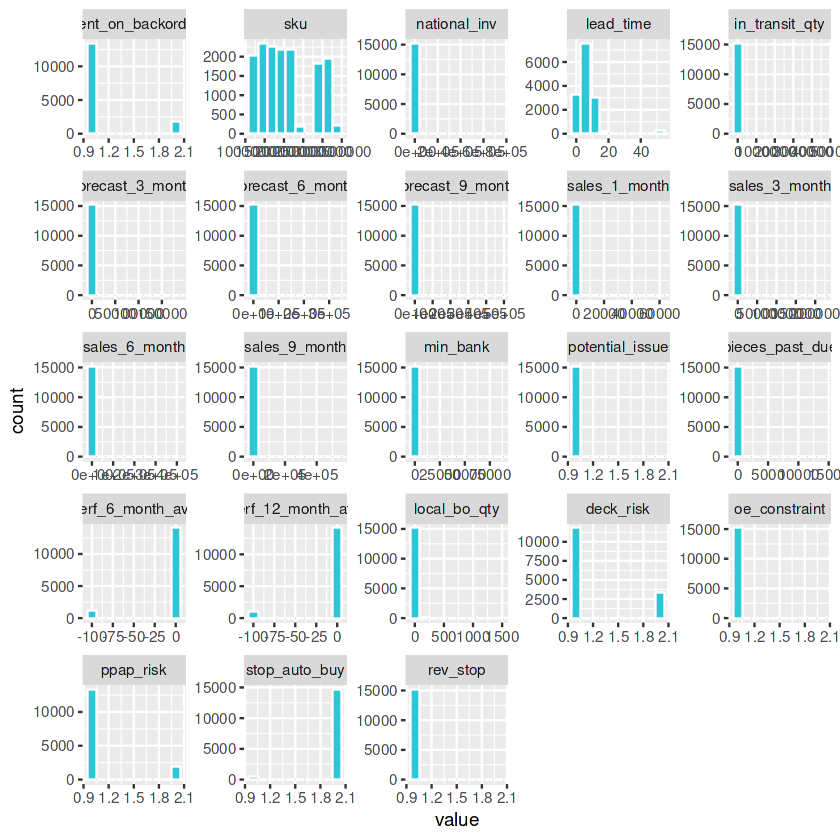

In [52]:
train_readable_tbl_challenge_1 %>% 
  relocate(went_on_backorder) %>% 
  plot_hist_facet()

**zero variance features**

In [62]:
recipe_obj_challenge_1 <- recipe(went_on_backorder ~ ., data = train_readable_tbl_challenge_1) %>%
    step_zv(all_predictors()) %>%
    step_dummy(all_nominal()) 

recipe_obj_challenge_1 %>% 
      prep()



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 22



── Training information 

Training data contained 15242 data points and 876 incomplete rows.



── Operations 

• Zero variance filter removed: <none> | Trained

• Dummy variables from: potential_issue, deck_risk, ... | Trained



**Bake train and test data**

In [63]:
recipe_obj_challenge_1 %>% 
      prep()



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 22



── Training information 

Training data contained 15242 data points and 876 incomplete rows.



── Operations 

• Zero variance filter removed: <none> | Trained

• Dummy variables from: potential_issue, deck_risk, ... | Trained



In [69]:
prep_recipe_challenge_1 <- prep(recipe_obj_challenge_1)

train_tbl_challenge_1 <- bake(prep_recipe_challenge_1, new_data = train_readable_tbl_challenge_1)

train_tbl_challenge_1 %>% glimpse()

test_tbl_challenge_1 <- bake(prep_recipe_challenge_1, new_data = test_readable_tbl_challenge_1)

Rows: 15,242
Columns: 23
$ sku                   <dbl> 1543349, 1411689, 1672722, 1119722, 1817291, 121…
$ national_inv          <dbl> 16, 147, 12, 109, 238, 2, 0, 217, 2, 6, 3, 0, 32…
$ lead_time             <dbl> 4, 2, 8, 2, 2, 8, 2, NA, NA, 9, 12, 2, 12, 8, 8,…
$ in_transit_qty        <dbl> 0, 46, 1, 0, 26, 0, 0, 73, 0, 0, 1, 0, 97, 0, 0,…
$ forecast_3_month      <dbl> 0, 270, 48, 0, 305, 0, 8, 0, 0, 0, 0, 18, 767, 0…
$ forecast_6_month      <dbl> 0, 530, 96, 0, 503, 0, 16, 0, 0, 0, 0, 18, 1577,…
$ forecast_9_month      <dbl> 0, 800, 144, 0, 701, 0, 20, 0, 0, 0, 0, 27, 2537…
$ sales_1_month         <dbl> 0, 127, 15, 0, 124, 0, 0, 104, 0, 0, 0, 7, 277, …
$ sales_3_month         <dbl> 0, 416, 43, 0, 312, 0, 0, 400, 0, 1, 0, 10, 965,…
$ sales_6_month         <dbl> 0, 679, 70, 0, 564, 0, 0, 814, 0, 1, 0, 19, 1884…
$ sales_9_month         <dbl> 0, 952, 95, 50, 796, 0, 0, 1294, 0, 2, 0, 28, 27…
$ min_bank              <dbl> 0, 92, 1, 3, 85, 0, 1, 105, 0, 0, 0, 1, 298, 0, …
$ pieces_past_d

**Correlation analysis**

In [70]:
train_tbl_challenge_1 %>%

        # Convert characters & factors to numeric
        mutate(across(where(is.character), as.factor)) %>%
        mutate(across(where(is.factor), as.numeric)) %>%
        
        # Correlation
        cor(use = "pairwise.complete.obs") %>% 
        as_tibble() %>%
        mutate(feature = names(.)) %>% 
        select(feature, went_on_backorder_Yes) %>% 
        
        # Filter the target, because we now the correlation is 100%
        filter(!(feature == "went_on_backorder_Yes")) %>% 
        
        # Convert character back to factors
        mutate(across(where(is.character), as_factor))
        

feature,went_on_backorder_Yes
<fct>,<dbl>
sku,-0.157644112
national_inv,-0.018106659
lead_time,-0.085883855
in_transit_qty,-0.018496258
forecast_3_month,0.004751517
forecast_6_month,-0.001476793
forecast_9_month,-0.003716025
sales_1_month,-0.010766938
sales_3_month,-0.011511817


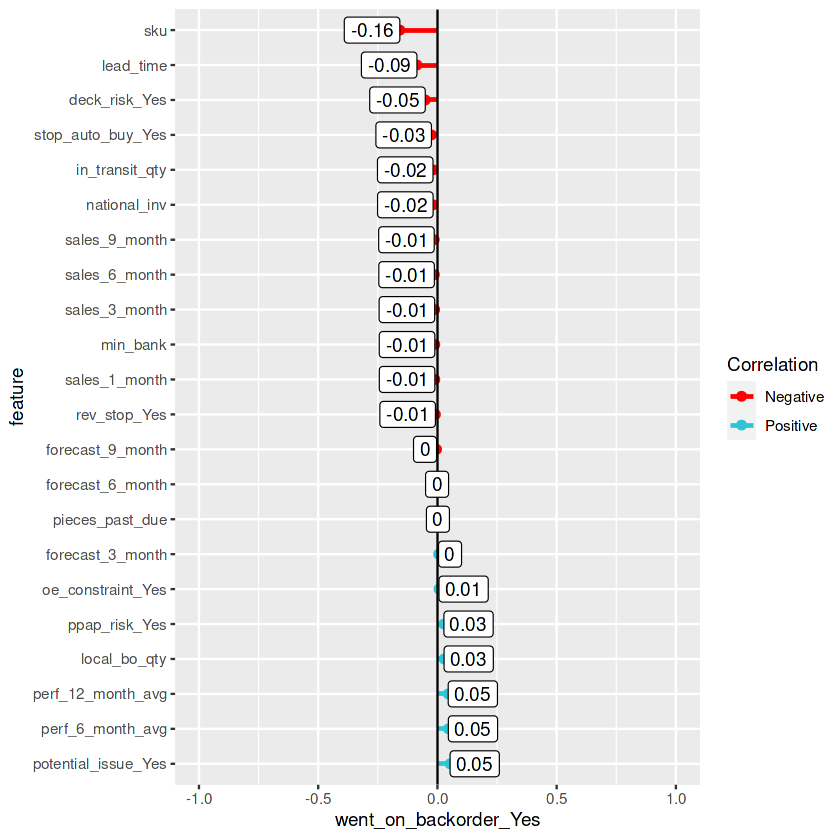

In [73]:
data_cor_challenge_1 <- train_tbl_challenge_1 %>%

  # Correlation
  get_cor(target = went_on_backorder_Yes, fct_reorder = T, fct_rev = T) %>%
  
  # Create label text
  mutate(feature_name_text = round(went_on_backorder_Yes, digits = 2)) %>%
  
  # Create flags so that we can change the color for poitive and negative
  mutate(Correlation = case_when(
    (went_on_backorder_Yes) >= 0 ~ "Positive",
    TRUE                   ~ "Negative") %>% as.factor())

data_cor_challenge_1 %>%
  ggplot(aes(x = went_on_backorder_Yes, y = feature, group = feature)) +
  geom_point(aes(color = Correlation), size = 2) +
  geom_segment(aes(xend = 0, yend = feature, color = Correlation), size = 1) +
  geom_vline(xintercept = 0, color = "black", size = 0.5) +
  expand_limits(x = c(-1, 1)) +
  scale_color_manual(values = c("red", "#2dc6d6")) +
  geom_label(aes(label = feature_name_text), hjust = "outward")

**ML with h2o**

In [83]:


product_backorders_tbl          <- read_csv("/kaggle/input/bdml-dataset/product_backorders.csv")
set.seed(seed = 1113)
split_obj                       <- rsample::initial_split(product_backorders_tbl, prop = 0.8)
train_readable_tbl_challenge_1              <- training(split_obj)
test_readable_tbl_challenge_1               <- testing(split_obj)

recipe_obj_challenge_1 <- recipe(went_on_backorder ~., data = train_readable_tbl_challenge_1) %>% 
    step_zv(all_predictors()) %>% 
step_dummy(all_nominal()) %>%

    prep()

train_tbl_challenge_1 <- bake(recipe_obj_challenge_1, new_data = train_readable_tbl_challenge_1)
test_tbl_challenge_1  <- bake(recipe_obj_challenge_1, new_data = test_readable_tbl_challenge_1)

Rows: 19053 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_bu...
dbl (16): sku, national_inv, lead_time, in_transit_qty, forecast_3_month, fo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [84]:
# Modeling
h2o.init()

# Split data into a training and a validation data frame
# Setting the seed is just for reproducability
split_h2o_challenge_1 <- h2o.splitFrame(as.h2o(train_tbl_challenge_1), ratios = c(0.8), seed = 1234)
train_h2o_challenge_1 <- split_h2o_challenge_1[[1]]
valid_h2o_challenge_1 <- split_h2o_challenge_1[[2]]
test_h2o_challenge_1  <- as.h2o(test_tbl_challenge_1)

# Set the target and predictors
#y <- "went_on_backorder"
y <- "went_on_backorder_Yes"
x <- setdiff(names(test_h2o_challenge_1), y)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 52 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.1 
    H2O cluster version age:    4 months and 6 days 
    H2O cluster name:           H2O_started_from_R_root_drs368 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.48 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.0.5 (2021-03-31) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is (4 months and 6 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html”



  |======================================================================| 100%
  |======================================================================| 100%


In [85]:
automl_models_h2o_challenge_1 <- h2o.automl(
  x = x,
  y = y,
  training_frame    = train_h2o_challenge_1,
  validation_frame  = valid_h2o_challenge_1,
  leaderboard_frame = test_h2o_challenge_1,
  max_runtime_secs  = 30,
  nfolds            = 5 
)

AutoML Details
Project Name: AutoML_2_20230615_92614 
Leader Model ID: StackedEnsemble_BestOfFamily_1_AutoML_2_20230615_92614 
Algorithm: stackedensemble 

Total Number of Models Trained: 11 
Start Time: 2023-06-15 09:26:15 UTC 
End Time: 2023-06-15 09:26:46 UTC 
Duration: 31 s

Leaderboard
                                                 model_id      rmse        mse
1  StackedEnsemble_BestOfFamily_1_AutoML_2_20230615_92614 0.2274288 0.05172388
2  StackedEnsemble_BestOfFamily_2_AutoML_2_20230615_92614 0.2276033 0.05180325
3     StackedEnsemble_AllModels_1_AutoML_2_20230615_92614 0.2280873 0.05202382
4                           GBM_1_AutoML_2_20230615_92614 0.2331500 0.05435892
5                       XGBoost_1_AutoML_2_20230615_92614 0.2390565 0.05714803
6                           GBM_3_AutoML_2_20230615_92614 0.2773478 0.07692180
7                           GBM_4_AutoML_2_20230615_92614 0.2873865 0.08259101
8                           DRF_1_AutoML_2_20230615_92614 0.2906600 0.084483

**Inspecting leaderboard**

In [86]:
typeof(automl_models_h2o_challenge_1)


slotNames(automl_models_h2o_challenge_1)


print(automl_models_h2o_challenge_1@leaderboard)

[1] "S4"

[1] "project_name"   "leader"         "leaderboard"    "event_log"     
[5] "modeling_steps" "training_info"

                                                model_id      rmse        mse
1 StackedEnsemble_BestOfFamily_1_AutoML_2_20230615_92614 0.2274288 0.05172388
2 StackedEnsemble_BestOfFamily_2_AutoML_2_20230615_92614 0.2276033 0.05180325
3    StackedEnsemble_AllModels_1_AutoML_2_20230615_92614 0.2280873 0.05202382
4                          GBM_1_AutoML_2_20230615_92614 0.2331500 0.05435892
5                      XGBoost_1_AutoML_2_20230615_92614 0.2390565 0.05714803
6                          GBM_3_AutoML_2_20230615_92614 0.2773478 0.07692180
        mae     rmsle mean_residual_deviance
1 0.1186797 0.1602786             0.05172388
2 0.1189404 0.1603574             0.05180325
3 0.1284594 0.1619046             0.05202382
4 0.1272050 0.1637353             0.05435892
5 0.1218485 0.1704640             0.05714803
6 0.1741581 0.1890820             0.07692180

[11 rows x 6 columns] 


**make predictions**

In [88]:
stacked_ensemble_h2o_challenge_1 <- h2o.getModel("StackedEnsemble_BestOfFamily_1_AutoML_2_20230615_92614")
stacked_ensemble_h2o_challenge_1

predictions <- h2o.predict(stacked_ensemble_h2o_challenge_1, newdata = as.h2o(test_tbl_challenge_1))

typeof(predictions)
## [1] "environment"

predictions_tbl <- predictions %>% as_tibble()

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  StackedEnsemble_BestOfFamily_1_AutoML_2_20230615_92614 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              2/3
3      # GBM base models (used / total)              1/1
4  # XGBoost base models (used / total)              1/1
5      # GLM base models (used / total)              0/1
6                 Metalearner algorithm              GLM
7    Metalearner fold assignment scheme           Random
8                    Metalearner nfolds                5
9               Metalearner fold_column               NA
10   Custom metalearner hyperparameters             None


H2ORegressionMetrics: stackedensemble
** Reported on training data. **

MSE:  0.02950502
RMSE:  0.1717703
MAE:  0.09251421
RMSLE:  0.1217242
Mean Residual Deviance :  0.02950502


H2ORegressionMetrics: stackedensemb

  |======================================================================| 100%
  |======================================================================| 100%


[1] "environment"

***

# Performance Measures
In this session, we take the H2O models we’ve developed and show you how to inspect, visualize, and communicate performance

# Business Case

# 1 Leaderboard Vizualization

In [ ]:
automl_models_h2o@leaderboard %>% 
              as_tibble() %>% 
              select(-c(mean_per_class_error, rmse, mse))

In [ ]:
# Visualize the H2O leaderboard to help with model selection
data_transformed_tbl <- automl_models_h2o@leaderboard %>%
        as_tibble() %>%
        select(-c(aucpr, mean_per_class_error, rmse, mse)) %>% 
        mutate(model_type = str_extract(model_id, "[^_]+")) %>%
        slice(1:15) %>% 
        rownames_to_column(var = "rowname") %>%
        # Visually this step will not change anything
        # It reorders the factors under the hood
        mutate(
          model_id   = as_factor(model_id) %>% reorder(auc),
          model_type = as.factor(model_type)
          ) %>% 
          pivot_longer(cols = -c(model_id, model_type, rowname), 
                       names_to = "key", 
                       values_to = "value", 
                       names_transform = list(key = forcats::fct_inorder)
                       ) %>% 
        mutate(model_id = paste0(rowname, ". ", model_id) %>% as_factor() %>% fct_rev())

**Plot Data**

In [ ]:
data_transformed_tbl %>%
        ggplot(aes(value, model_id, color = model_type)) +
        geom_point(size = 3) +
        geom_label(aes(label = round(value, 2), hjust = "inward")) +
        
        # Facet to break out logloss and auc
        facet_wrap(~ key, scales = "free_x") +
        labs(title = "Leaderboard Metrics",
             subtitle = paste0("Ordered by: ", "auc"),
             y = "Model Postion, Model ID", x = "") + 
        theme(legend.position = "bottom")

**Function for creating leaderboard plot data**

In [ ]:
plot_h2o_leaderboard <- function(h2o_leaderboard, order_by = c("auc", "logloss"), 
                                 n_max = 20, size = 4, include_lbl = TRUE) {

    # Setup inputs
    # adjust input so that all formats are working
    order_by <- tolower(order_by[[1]])

    leaderboard_tbl <- h2o_leaderboard %>%
        as.tibble() %>%
        select(-c(aucpr, mean_per_class_error, rmse, mse)) %>% 
        mutate(model_type = str_extract(model_id, "[^_]+")) %>%
        rownames_to_column(var = "rowname") %>%
        mutate(model_id = paste0(rowname, ". ", model_id) %>% as.factor())

    # Transformation
    if (order_by == "auc") {

        data_transformed_tbl <- leaderboard_tbl %>%
            slice(1:n_max) %>%
            mutate(
                model_id   = as_factor(model_id) %>% reorder(auc),
                model_type = as.factor(model_type)
            ) %>%
                pivot_longer(cols = -c(model_id, model_type, rowname), 
                       names_to = "key", 
                       values_to = "value", 
                       names_transform = list(key = forcats::fct_inorder)
                       )

    } else if (order_by == "logloss") {

        data_transformed_tbl <- leaderboard_tbl %>%
            slice(1:n_max) %>%
            mutate(
                model_id   = as_factor(model_id) %>% reorder(logloss) %>% fct_rev(),
                model_type = as.factor(model_type)
            ) %>%
            pivot_longer(cols = -c(model_id, model_type, rowname), 
                       names_to = "key", 
                       values_to = "value", 
                       names_transform = list(key = forcats::fct_inorder)
                       )

    } else {
        # If nothing is supplied
        stop(paste0("order_by = '", order_by, "' is not a permitted option."))
    }

    # Visualization
    g <- data_transformed_tbl %>%
        ggplot(aes(value, model_id, color = model_type)) +
        geom_point(size = size) +
        facet_wrap(~ key, scales = "free_x") +
        labs(title = "Leaderboard Metrics",
             subtitle = paste0("Ordered by: ", toupper(order_by)),
             y = "Model Postion, Model ID", x = "")

    if (include_lbl) g <- g + geom_label(aes(label = round(value, 2), 
                                             hjust = "inward"))

    return(g)

}

# 2 Grid Search

In [ ]:
deeplearning_h2o <- h2o.loadModel("/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230614_212205")

# Take a look for the metrics on the training data set
# For my model the total error in the confusion matrix is ~15 %
deeplearning_h2o

# We want to see how it performs for the testing data frame
test_tbl

# Make sure to convert it to an h20 object
# Accuracy of the confusion matrix shows ~85 % accuracy
h2o.performance(deeplearning_h2o, newdata = as.h2o(test_tbl))

**We can adjust the hyper parameters by adding random values to lists or vectors:**

In [ ]:
deeplearning_grid_01 <- h2o.grid(

    # See help page for available algos
    algorithm = "deeplearning",
    
    # I just use the same as the object
    grid_id = "deeplearning_grid_01",
    
    # The following is for ?h2o.deeplearning()
    # predictor and response variables
    x = x,
    y = y,
    
    # training and validation frame and crossfold validation
    training_frame   = train_h2o,
    validation_frame = valid_h2o,
    nfolds = 5,
    
    # Hyperparamters: Use deeplearning_h2o@allparameters to see all
    hyper_params = list(
        # Use some combinations (the first one was the original)
        hidden = list(c(10, 10, 10), c(50, 20, 10), c(20, 20, 20)),
        epochs = c(10, 50, 100)
    )
)

In [ ]:
deeplearning_grid_01

**Sort by a different metric**

In [ ]:
h2o.getGrid(grid_id = "deeplearning_grid_01", sort_by = "auc", decreasing = TRUE)

**To see if one of the model performs better on the test set pull than model out with h2o.getModel():**

In [ ]:
deeplearning_grid_01_model_1 <- h2o.getModel("deeplearning_grid_01_model_1")

deeplearning_grid_01_model_1 %>% h2o.auc(train = T, valid = T, xval = T)
##     train     valid      xval 
## 0.9093134 0.7922078 0.8299115 

# We can tell the model is overfitting because of the huge difference between training AUC and the validation / cross validation AUC

# Run it on the test data
deeplearning_grid_01_model_1 %>%
    h2o.performance(newdata = as.h2o(test_tbl))
# error is ~9.5 %

# 3 H2O Performance
* Using the leaderboard to get 3 different models

In [ ]:
# 4. Assessing Performance ----
# If saved, then load. 
#stacked_ensemble_h2o <- h2o.loadModel("04_Modeling/h2o_models/StackedEnsemble_AllModels_AutoML_20200826_112031")
#deeplearning_h2o     <- h2o.loadModel("04_Modeling/h2o_models/DeepLearning_grid__1_AutoML_20200826_112031_model_1")
#glm_h2o              <- h2o.loadModel("04_Modeling/h2o_models/GLM_1_AutoML_20200826_112031")

h2o.getModel("StackedEnsemble_BestOfFamily_2_AutoML_1_20230614_212205") %>%
  h2o.saveModel(path = "/kaggle/working/")

In [ ]:
h2o.getModel("GBM_4_AutoML_1_20230614_212205") %>%
  h2o.saveModel(path = "/kaggle/working/")

In [ ]:
 h2o.getModel("GLM_1_AutoML_1_20230614_212205") %>%
  h2o.saveModel(path = "/kaggle/working/")

In [ ]:
stacked_ensemble_h2o <- h2o.loadModel("/kaggle/working/StackedEnsemble_BestOfFamily_2_AutoML_1_20230614_212205")
deeplearning_h2o <- h2o.loadModel("/kaggle/working/GBM_4_AutoML_1_20230614_212205")
glm_h2o              <- h2o.loadModel("/kaggle/working/h20_models/GLM_1_AutoML_1_20230614_212205")

**Create a performance object**

In [ ]:
performance_h2o <- h2o.performance(stacked_ensemble_h2o, newdata = as.h2o(test_tbl))

typeof(performance_h2o)
performance_h2o %>% slotNames()

# We are focusing on the slot metrics. This slot contains all possible metrics
performance_h2o@metrics

**Classifier summary metrics**

In [ ]:
# Classifier Summary Metrics

h2o.auc(performance_h2o, train = T, valid = T, xval = T)
## [1] 0.8588763

# Caution: "train, "val", and "xval" arugments only work for models (not performance objects)
h2o.auc(stacked_ensemble_h2o, train = T, valid = T, xval = T)
##     train     valid      xval 
## 0.9892475 0.8219522 0.8383290 

h2o.giniCoef(performance_h2o)
## [1] 0.7177527
h2o.logloss(performance_h2o)
## [1] 0.2941769

# result for the training data
h2o.confusionMatrix(stacked_ensemble_h2o)
## Confusion Matrix (vertical: actual; across: predicted)  for max f1 @ threshold = 0.358554294328892:
##         No Yes    Error      Rate
## No     871  20 0.022447   =20/891
## Yes     23 151 0.132184   =23/174
## Totals 894 171 0.040376  =43/1065

# result for the hold out set
h2o.confusionMatrix(performance_h2o)
## Confusion Matrix (vertical: actual; across: predicted)  for max f1 @ threshold = 0.498049256506051:
##         No Yes    Error     Rate
## No     179   9 0.047872   =9/188
## Yes     14  18 0.437500   =14/32
## Totals 193  27 0.104545  =23/220

**Precision vs recall plot**

In [ ]:
# Precision vs Recall Plot

# This is on the test set
performance_tbl <- performance_h2o %>%
    h2o.metric() %>%
    as.tibble() 

performance_tbl %>% 
  glimpse()

In [ ]:
theme_new <- theme(
      legend.position  = "bottom",
      legend.key       = element_blank(),,
      panel.background = element_rect(fill   = "transparent"),
      panel.border     = element_rect(color = "black", fill = NA, size = 0.5),
      panel.grid.major = element_line(color = "grey", size = 0.333)
      ) 

In [ ]:
performance_tbl %>%
    filter(f1 == max(f1))

performance_tbl %>%
    ggplot(aes(x = threshold)) +
    geom_line(aes(y = precision), color = "blue", size = 1) +
    geom_line(aes(y = recall), color = "red", size = 1) +
    
    # Insert line where precision and recall are harmonically optimized
    geom_vline(xintercept = h2o.find_threshold_by_max_metric(performance_h2o, "f1")) +
    labs(title = "Precision vs Recall", y = "value") +
    theme_new

# Performance chart for scientist

**ROC plot**

In [ ]:
# ROC Plot

path <- "StackedEnsemble_BestOfFamily_2_AutoML_1_20230614_212205"

load_model_performance_metrics <- function(path, test_tbl) {
    
    model_h2o <- h2o.loadModel(path)
    perf_h2o  <- h2o.performance(model_h2o, newdata = as.h2o(test_tbl)) 
    
    perf_h2o %>%
        h2o.metric() %>%
        as_tibble() %>%
        mutate(auc = h2o.auc(perf_h2o)) %>%
        select(tpr, fpr, auc)
    
}

model_metrics_tbl <- fs::dir_info(path = "/kaggle/working/") %>%
    select(path) %>%
    mutate(metrics = map(path, load_model_performance_metrics, test_tbl)) %>%
    unnest(cols = metrics)

In [ ]:
model_metrics_tbl %>%
    mutate(
        # Extract the model names
        path = str_split(path, pattern = "/", simplify = T)[,3] %>% as_factor(),
        auc  = auc %>% round(3) %>% as.character() %>% as_factor()
        ) %>%
    ggplot(aes(fpr, tpr, color = path, linetype = auc)) +
    geom_line(size = 1) +
    
    # just for demonstration purposes
    geom_abline(color = "red", linetype = "dotted") +
    
    theme_new +
    theme(
      legend.direction = "vertical",
      ) +
    labs(
        title = "ROC Plot",
        subtitle = "Performance of 3 Top Performing Models"
    )

**Precision vs Recall**

In [ ]:
# Precision vs Recall

load_model_performance_metrics <- function(path, test_tbl) {
    
    model_h2o <- h2o.loadModel(path)
    perf_h2o  <- h2o.performance(model_h2o, newdata = as.h2o(test_tbl)) 
    
    perf_h2o %>%
        h2o.metric() %>%
        as_tibble() %>%
        mutate(auc = h2o.auc(perf_h2o)) %>%
        select(tpr, fpr, auc, precision, recall)
    
}

model_metrics_tbl <- fs::dir_info(path = "/kaggle/working/") %>%
    select(path) %>%
    mutate(metrics = map(path, load_model_performance_metrics, test_tbl)) %>%
    unnest(cols = metrics)

model_metrics_tbl %>%
    mutate(
        path = str_split(path, pattern = "/", simplify = T)[,3] %>% as_factor(),
        auc  = auc %>% round(3) %>% as.character() %>% as_factor()
    ) %>%
    ggplot(aes(recall, precision, color = path, linetype = auc)) +
    geom_line(size = 1) +
    theme_new + 
    theme(
      legend.direction = "vertical",
      ) +
    labs(
        title = "Precision vs Recall Plot",
        subtitle = "Performance of 3 Top Performing Models"
    )

# Performance chart for business people

In [ ]:
# Gain & Lift

ranked_predictions_tbl <- predictions_tbl %>%
    bind_cols(test_tbl) %>%
    select(predict:Yes, Attrition) %>%
    # Sorting from highest to lowest class probability
    arrange(desc(Yes))

ranked_predictions_tbl

* 10th ntile: highest probability of leaving, 18 of 22 have left. 

In [ ]:
ranked_predictions_tbl %>%
    mutate(ntile = ntile(Yes, n = 10)) %>%
    group_by(ntile) %>%
    summarise(
        cases = n(),
        responses = sum(Attrition == "Yes")
    ) %>%
    arrange(desc(ntile))

In [ ]:
calculated_gain_lift_tbl <- ranked_predictions_tbl %>%
    mutate(ntile = ntile(Yes, n = 10)) %>%
    group_by(ntile) %>%
    summarise(
        cases = n(),
        responses = sum(Attrition == "Yes")
    ) %>%
    arrange(desc(ntile)) %>%
    
    # Add group numbers (opposite of ntile)
    mutate(group = row_number()) %>%
    select(group, cases, responses) %>%
    
    # Calculations
    mutate(
        cumulative_responses = cumsum(responses),
        pct_responses        = responses / sum(responses),
        gain                 = cumsum(pct_responses),
        cumulative_pct_cases = cumsum(cases) / sum(cases),
        lift                 = gain / cumulative_pct_cases,
        gain_baseline        = cumulative_pct_cases,
        lift_baseline        = gain_baseline / cumulative_pct_cases
    )

calculated_gain_lift_tbl 

In [ ]:
gain_lift_tbl <- performance_h2o %>%
    h2o.gainsLift() %>%
    as.tibble()

## Gain Chart

gain_transformed_tbl <- gain_lift_tbl %>% 
    select(group, cumulative_data_fraction, cumulative_capture_rate, cumulative_lift) %>%
    select(-contains("lift")) %>%
    mutate(baseline = cumulative_data_fraction) %>%
    rename(gain     = cumulative_capture_rate) %>%
    # prepare the data for the plotting (for the color and group aesthetics)
    pivot_longer(cols = c(gain, baseline), values_to = "value", names_to = "key")

gain_transformed_tbl %>%
    ggplot(aes(x = cumulative_data_fraction, y = value, color = key)) +
    geom_line(size = 1.5) +
    labs(
        title = "Gain Chart",
        x = "Cumulative Data Fraction",
        y = "Gain"
    ) +
    theme_new

In [ ]:
## Lift Plot

lift_transformed_tbl <- gain_lift_tbl %>% 
    select(group, cumulative_data_fraction, cumulative_capture_rate, cumulative_lift) %>%
    select(-contains("capture")) %>%
    mutate(baseline = 1) %>%
    rename(lift = cumulative_lift) %>%
    pivot_longer(cols = c(lift, baseline), values_to = "value", names_to = "key")

lift_transformed_tbl %>%
    ggplot(aes(x = cumulative_data_fraction, y = value, color = key)) +
    geom_line(size = 1.5) +
    labs(
        title = "Lift Chart",
        x = "Cumulative Data Fraction",
        y = "Lift"
    ) +
    theme_new

In [ ]:
# 5. Performance Visualization ----  
library(cowplot)
library(glue)


# set values to test the function while building it
h2o_leaderboard <- automl_models_h2o@leaderboard
newdata <- test_tbl
order_by <- "auc"
max_models <- 4
size <- 1

plot_h2o_performance <- function(h2o_leaderboard, newdata, order_by = c("auc", "logloss"),
                                 max_models = 3, size = 1.5) {
    
    # Inputs
    
    leaderboard_tbl <- h2o_leaderboard %>%
        as_tibble() %>%
        slice(1:max_models)
    
    newdata_tbl <- newdata %>%
        as_tibble()
    
    # Selecting the first, if nothing is provided
    order_by      <- tolower(order_by[[1]]) 
    
    # Convert string stored in a variable to column name (symbol)
    order_by_expr <- rlang::sym(order_by)

    # Turn of the progress bars ( opposite h2o.show_progress())
    h2o.no_progress()
    
    # 1. Model metrics
    
    get_model_performance_metrics <- function(model_id, test_tbl) {
        
        model_h2o <- h2o.getModel(model_id)
        perf_h2o  <- h2o.performance(model_h2o, newdata = as.h2o(test_tbl))
        
        perf_h2o %>%
            h2o.metric() %>%
            as.tibble() %>%
            select(threshold, tpr, fpr, precision, recall)
        
    }
    
    model_metrics_tbl <- leaderboard_tbl %>%
        mutate(metrics = map(model_id, get_model_performance_metrics, newdata_tbl)) %>%
        unnest(cols = metrics) %>%
        mutate(
          model_id = as_factor(model_id) %>% 
                      # programmatically reorder factors depending on order_by
                      fct_reorder(!! order_by_expr, 
                                  .desc = ifelse(order_by == "auc", TRUE, FALSE)),
          auc      = auc %>% 
                      round(3) %>% 
                      as.character() %>% 
                      as_factor() %>% 
                      fct_reorder(as.numeric(model_id)),
          logloss  = logloss %>% 
                      round(4) %>% 
                      as.character() %>% 
                      as_factor() %>% 
                      fct_reorder(as.numeric(model_id))
        )
    
    
    # 1A. ROC Plot
    
    p1 <- model_metrics_tbl %>%
        ggplot(aes(fpr, tpr, color = model_id, linetype = !! order_by_expr)) +
        geom_line(size = size) +
        theme_new +
        labs(title = "ROC", x = "FPR", y = "TPR") +
        theme(legend.direction = "vertical") 
        
    
    # 1B. Precision vs Recall
    
    p2 <- model_metrics_tbl %>%
        ggplot(aes(recall, precision, color = model_id, linetype = !! order_by_expr)) +
        geom_line(size = size) +
        theme_new +
        labs(title = "Precision Vs Recall", x = "Recall", y = "Precision") +
        theme(legend.position = "none") 
    
    
    # 2. Gain / Lift
    
    get_gain_lift <- function(model_id, test_tbl) {
        
        model_h2o <- h2o.getModel(model_id)
        perf_h2o  <- h2o.performance(model_h2o, newdata = as.h2o(test_tbl)) 
        
        perf_h2o %>%
            h2o.gainsLift() %>%
            as.tibble() %>%
            select(group, cumulative_data_fraction, cumulative_capture_rate, cumulative_lift)
        
    }
    
    gain_lift_tbl <- leaderboard_tbl %>%
        mutate(metrics = map(model_id, get_gain_lift, newdata_tbl)) %>%
        unnest(cols = metrics) %>%
        mutate(
            model_id = as_factor(model_id) %>% 
                fct_reorder(!! order_by_expr, 
                            .desc = ifelse(order_by == "auc", TRUE, FALSE)),
            auc  = auc %>% 
                round(3) %>% 
                as.character() %>% 
                as_factor() %>% 
                fct_reorder(as.numeric(model_id)),
            logloss = logloss %>% 
                round(4) %>% 
                as.character() %>% 
                as_factor() %>% 
                fct_reorder(as.numeric(model_id))
        ) %>%
        rename(
            gain = cumulative_capture_rate,
            lift = cumulative_lift
        ) 
    
    # 2A. Gain Plot
    
    p3 <- gain_lift_tbl %>%
        ggplot(aes(cumulative_data_fraction, gain, 
                          color = model_id, linetype = !! order_by_expr)) +
        geom_line(size = size,) +
        geom_segment(x = 0, y = 0, xend = 1, yend = 1, 
                     color = "red", size = size, linetype = "dotted") +
        theme_new +
        expand_limits(x = c(0, 1), y = c(0, 1)) +
        labs(title = "Gain",
             x = "Cumulative Data Fraction", y = "Gain") +
        theme(legend.position = "none")
    
    # 2B. Lift Plot
    
    p4 <- gain_lift_tbl %>%
        ggplot(aes(cumulative_data_fraction, lift, 
                          color = model_id, linetype = !! order_by_expr)) +
        geom_line(size = size) +
        geom_segment(x = 0, y = 1, xend = 1, yend = 1, 
                     color = "red", size = size, linetype = "dotted") +
        theme_new +
        expand_limits(x = c(0, 1), y = c(0, 1)) +
        labs(title = "Lift",
             x = "Cumulative Data Fraction", y = "Lift") +
        theme(legend.position = "none") 
    
    
    # Combine using cowplot
    
    # cowplot::get_legend extracts a legend from a ggplot object
    p_legend <- get_legend(p1)
    # Remove legend from p1
    p1 <- p1 + theme(legend.position = "none")
    
    # cowplot::plt_grid() combines multiple ggplots into a single cowplot object
    p <- cowplot::plot_grid(p1, p2, p3, p4, ncol = 2)
    
    # cowplot::ggdraw() sets up a drawing layer
    p_title <- ggdraw() + 
    
        # cowplot::draw_label() draws text on a ggdraw layer / ggplot object
        draw_label("H2O Model Metrics", size = 18, fontface = "bold", 
                   color = "#2C3E50")
    
    p_subtitle <- ggdraw() + 
        draw_label(glue("Ordered by {toupper(order_by)}"), size = 10,  
                   color = "#2C3E50")
    
    # Combine everything
    ret <- plot_grid(p_title, p_subtitle, p, p_legend, 
    
                     # Adjust the relative spacing, so that the legends always fits
                     ncol = 1, rel_heights = c(0.05, 0.05, 1, 0.05 * max_models))
    
    h2o.show_progress()
    
    return(ret)
    
}

automl_models_h2o@leaderboard %>%
    plot_h2o_performance(newdata = test_tbl, order_by = "logloss", 
                         size = 0.5, max_models = 4)